In [1]:
# Parameters - Constants
MAX_MSL = 0.4
MAX_TREE_DEPTH = 20
TRAIN_FRACTION = 0.7
RANDOM_SEED = 867201
CV_VALIDATE_SPLIT = 5

In [112]:
# Libraries to import
import re
import numpy as np
import pandas as pd
from copy import deepcopy


from sklearn import tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold



import matplotlib
from matplotlib import pyplot as plt

import seaborn as sns

# font set for graphs
font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 8}
matplotlib.rc('font', **font)


In [124]:
def metric_statistics_decision_tree(dtree,
                                    training_features,
                                    training_class,
                                    test_features,
                                    test_class,
                                    num_cv=5,
                                    num_repeat=10):

    skfold=RepeatedStratifiedKFold(n_splits=num_cv,
                                   n_repeats=num_repeat,
                                   random_state=RANDOM_SEED)
    cv_fold=0
    scores=[]

    collect_vals_predictions = []

    for tr,va in skfold.split(training_features,training_class):
    
        dtree.fit(training_features[tr,:],training_class[tr])
        pred_test_y=dtree.predict(training_features[va,:])
        proba_test_y = dtree.predict_proba(training_features[va,:])

        Accuracy= 100*metrics.accuracy_score(training_class[va],pred_test_y)
        Recall=100*metrics.recall_score(training_class[va],pred_test_y)
        Precision= 100*metrics.precision_score(training_class[va],pred_test_y)
        FPR = 100*(1-metrics.recall_score(training_class[va],pred_test_y,pos_label=0))
        roc_auc = 100*metrics.roc_auc_score(training_class[va],proba_test_y[:,1])
        cv_fold = cv_fold+1
        collect_vals_predictions.append({'decision_tree': deepcopy(dtree),
                                         'cv_fold':cv_fold,
                                         'validation':training_class[va].copy(),
                                         'model_prediction':pred_test_y,
                                         'model_probability':proba_test_y})
        scores.append([cv_fold, Accuracy, Recall, Precision, FPR, roc_auc,dtree.tree_.max_depth])

    # All the data
    dtree.fit(training_features,training_class)
    pred_test_y=dtree.predict(test_features)
    proba_test_y=dtree.predict_proba(test_features)

    Accuracy= 100*metrics.accuracy_score(test_class,pred_test_y)
    Recall=100*metrics.recall_score(test_class,pred_test_y)
    Precision= 100*metrics.precision_score(test_class,pred_test_y)
    FPR = 100*(1-metrics.recall_score(test_class,pred_test_y,pos_label=0))
    roc_auc = 100*metrics.roc_auc_score(test_class,proba_test_y[:,1])
    cv_fold=0
    collect_vals_predictions.append({'decision_tree': deepcopy(dtree),
                                     'cv_fold':cv_fold,
                                     'validation':test_class.copy(),
                                     'model_prediction':pred_test_y,
                                     'model_probability':proba_test_y})

    
    scores.append([cv_fold, Accuracy, Recall, Precision, FPR, roc_auc,dtree.tree_.max_depth])
    scores=pd.DataFrame.from_records(scores,columns=['CV_Fold','Accuracy','Recall','Precision','FPR','ROC_AUC','Max_Depth'])

    metrics_summary = scores#[['Accuracy','Recall','Precision','FPR','ROC_AUC']]
    return metrics_summary,collect_vals_predictions

In [4]:
# Read Data into raw data
raw_data = pd.read_csv(r"..\..\data\diabetes\diabetes.csv")

In [5]:
classification = 'Outcome'
features = list(raw_data.columns)
features.remove(classification)

In [6]:
# Split into train and test
training_data = raw_data.sample(frac=TRAIN_FRACTION,random_state=RANDOM_SEED)
training_class = training_data.loc[:,classification].values
training_features = training_data.loc[:,features].values


test_data = raw_data.drop(index=training_data.index)
test_class = test_data.loc[:,classification].values
test_features = test_data.loc[:,features].values

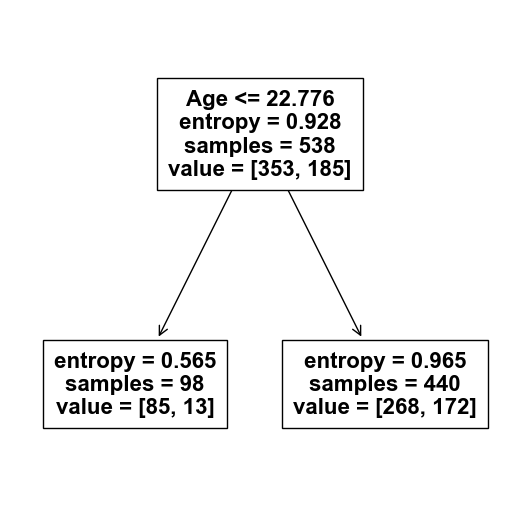

In [7]:
depth = 1
criterion = 'entropy'
splitter = 'random'
entropy_depth1_random_tree =  DecisionTreeClassifier(random_state=RANDOM_SEED,
                                                     criterion=criterion,
                                                     max_depth=depth,
                                                     splitter=splitter)

entropy_depth1_random_tree.fit(training_features,training_class)

fig=plt.figure(figsize=[5,5])
ax=fig.add_axes([0,0,1,1])
txt=tree.plot_tree(entropy_depth1_random_tree,fontsize=8,proportion=False,ax=ax)
ycollect=[]
sign=1
for tx in txt:
    val = tx.get_text()
    num = re.search(r'x\[(\d+)\]',val) 
    if(num is not None): 
        num=int(num.group()[2:-1])
        tx.set_text(tx.get_text().replace(f'x[{num}]',training_data.columns[num]))
    tx.set_fontsize(16)
plt.savefig('Plots/Random_Depth1_Entropy_Metric_tree.svg',format='svg')
plt.show()

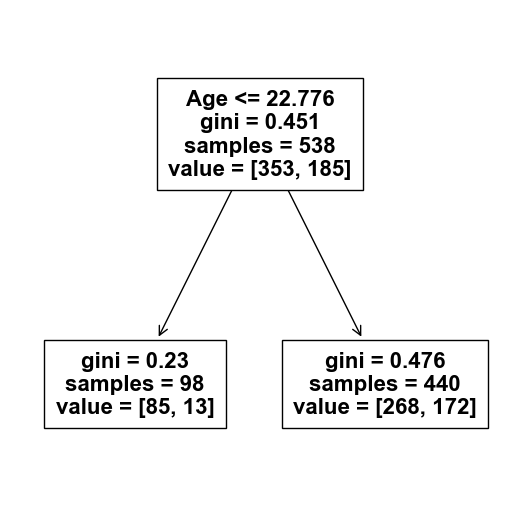

In [8]:
depth = 1
criterion = 'gini'
splitter = 'random'
gini_depth1_random_tree =  DecisionTreeClassifier(random_state=RANDOM_SEED,
                                                     criterion=criterion,
                                                     max_depth=depth,
                                                     splitter=splitter)

gini_depth1_random_tree.fit(training_features,training_class)

fig=plt.figure(figsize=[5,5])
ax=fig.add_axes([0,0,1,1])
txt=tree.plot_tree(gini_depth1_random_tree,fontsize=8,proportion=False,ax=ax)
ycollect=[]
sign=1
for tx in txt:
    val = tx.get_text()
    num = re.search(r'x\[(\d+)\]',val) 
    if(num is not None): 
        num=int(num.group()[2:-1])
        tx.set_text(tx.get_text().replace(f'x[{num}]',training_data.columns[num]))
    tx.set_fontsize(16)
plt.savefig('Plots/Random_Depth1_Gini_Metric_tree.svg',format='svg')
plt.show()

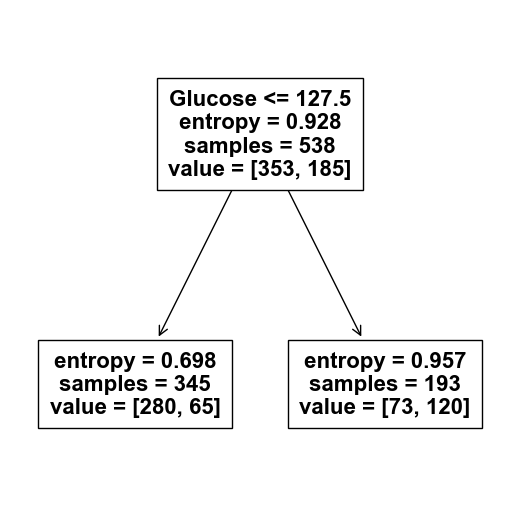

In [9]:
depth = 1
criterion = 'entropy'
splitter = 'best'
entropy_depth1_best_tree =  DecisionTreeClassifier(random_state=RANDOM_SEED,
                                                     criterion=criterion,
                                                     max_depth=depth,
                                                     splitter=splitter)

entropy_depth1_best_tree.fit(training_features,training_class)

fig=plt.figure(figsize=[5,5])
ax=fig.add_axes([0,0,1,1])
txt=tree.plot_tree(entropy_depth1_best_tree,fontsize=8,proportion=False,ax=ax)
ycollect=[]
sign=1
for tx in txt:
    val = tx.get_text()
    num = re.search(r'x\[(\d+)\]',val) 
    if(num is not None): 
        num=int(num.group()[2:-1])
        tx.set_text(tx.get_text().replace(f'x[{num}]',training_data.columns[num]))
    tx.set_fontsize(16)
plt.savefig('Plots/Best_Depth1_Entropy_Metric_tree.svg',format='svg')
plt.show()

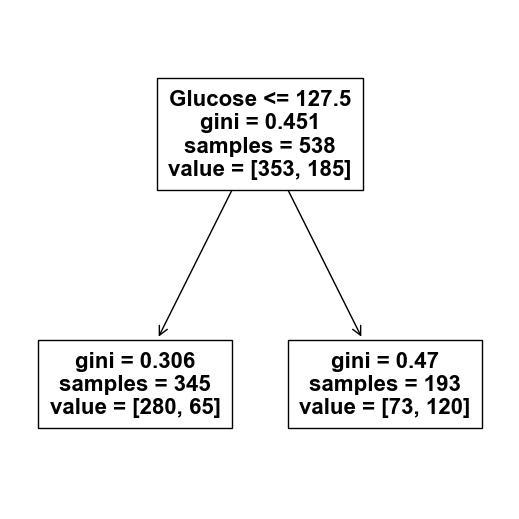

In [10]:
depth = 1
criterion = 'gini'
splitter = 'best'
gini_depth1_best_tree =  DecisionTreeClassifier(random_state=RANDOM_SEED,
                                                     criterion=criterion,
                                                     max_depth=depth,
                                                     splitter=splitter)

gini_depth1_best_tree.fit(training_features,training_class)

fig=plt.figure(figsize=[5,5])
ax=fig.add_axes([0,0,1,1])
txt=tree.plot_tree(gini_depth1_best_tree,fontsize=8,proportion=False,ax=ax)
ycollect=[]
sign=1
for tx in txt:
    val = tx.get_text()
    num = re.search(r'x\[(\d+)\]',val) 
    if(num is not None): 
        num=int(num.group()[2:-1])
        tx.set_text(tx.get_text().replace(f'x[{num}]',training_data.columns[num]))
    tx.set_fontsize(16)
plt.savefig('Plots/Best_Depth1_Gini_Metric_tree.svg',format='svg')
plt.show()

In [11]:
criterion='entropy'
depth = 2
entropy_depth2_tree = DecisionTreeClassifier(random_state=RANDOM_SEED,criterion=criterion,max_depth=depth)
scores,collection_vals = metric_statistics_decision_tree(entropy_depth2_tree,training_features,training_class,test_features,test_class,num_cv=5,num_repeat=5)
scores.to_csv('Results/Performance_Depth2_Entropy_Tree.csv',index=False)
score_summary=scores[['Accuracy','Recall','Precision','FPR','ROC_AUC']].describe().T
score_summary[['mean','std']].T

Accuracy     Recall  Precision        FPR    ROC_AUC
mean  74.524259  48.170228  69.426078  11.626831  68.271699
std    3.303535  11.851639   7.664283   4.996324   4.818301

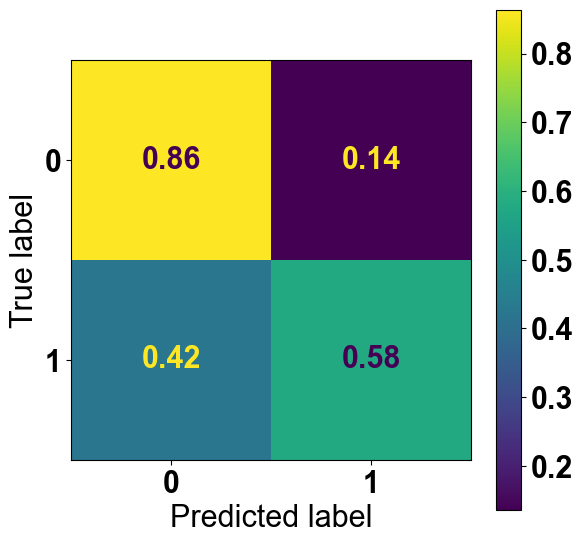

In [12]:
fig=plt.figure(figsize=[5,5])
ax = fig.add_axes([0,0,1,1])
metrics.ConfusionMatrixDisplay.from_predictions(test_class,collection_vals[-1]['model_prediction'],normalize='true',ax=ax)
plt.savefig('Plots/ConfusionMatrix_Depth2_Entropy.svg',format='svg')

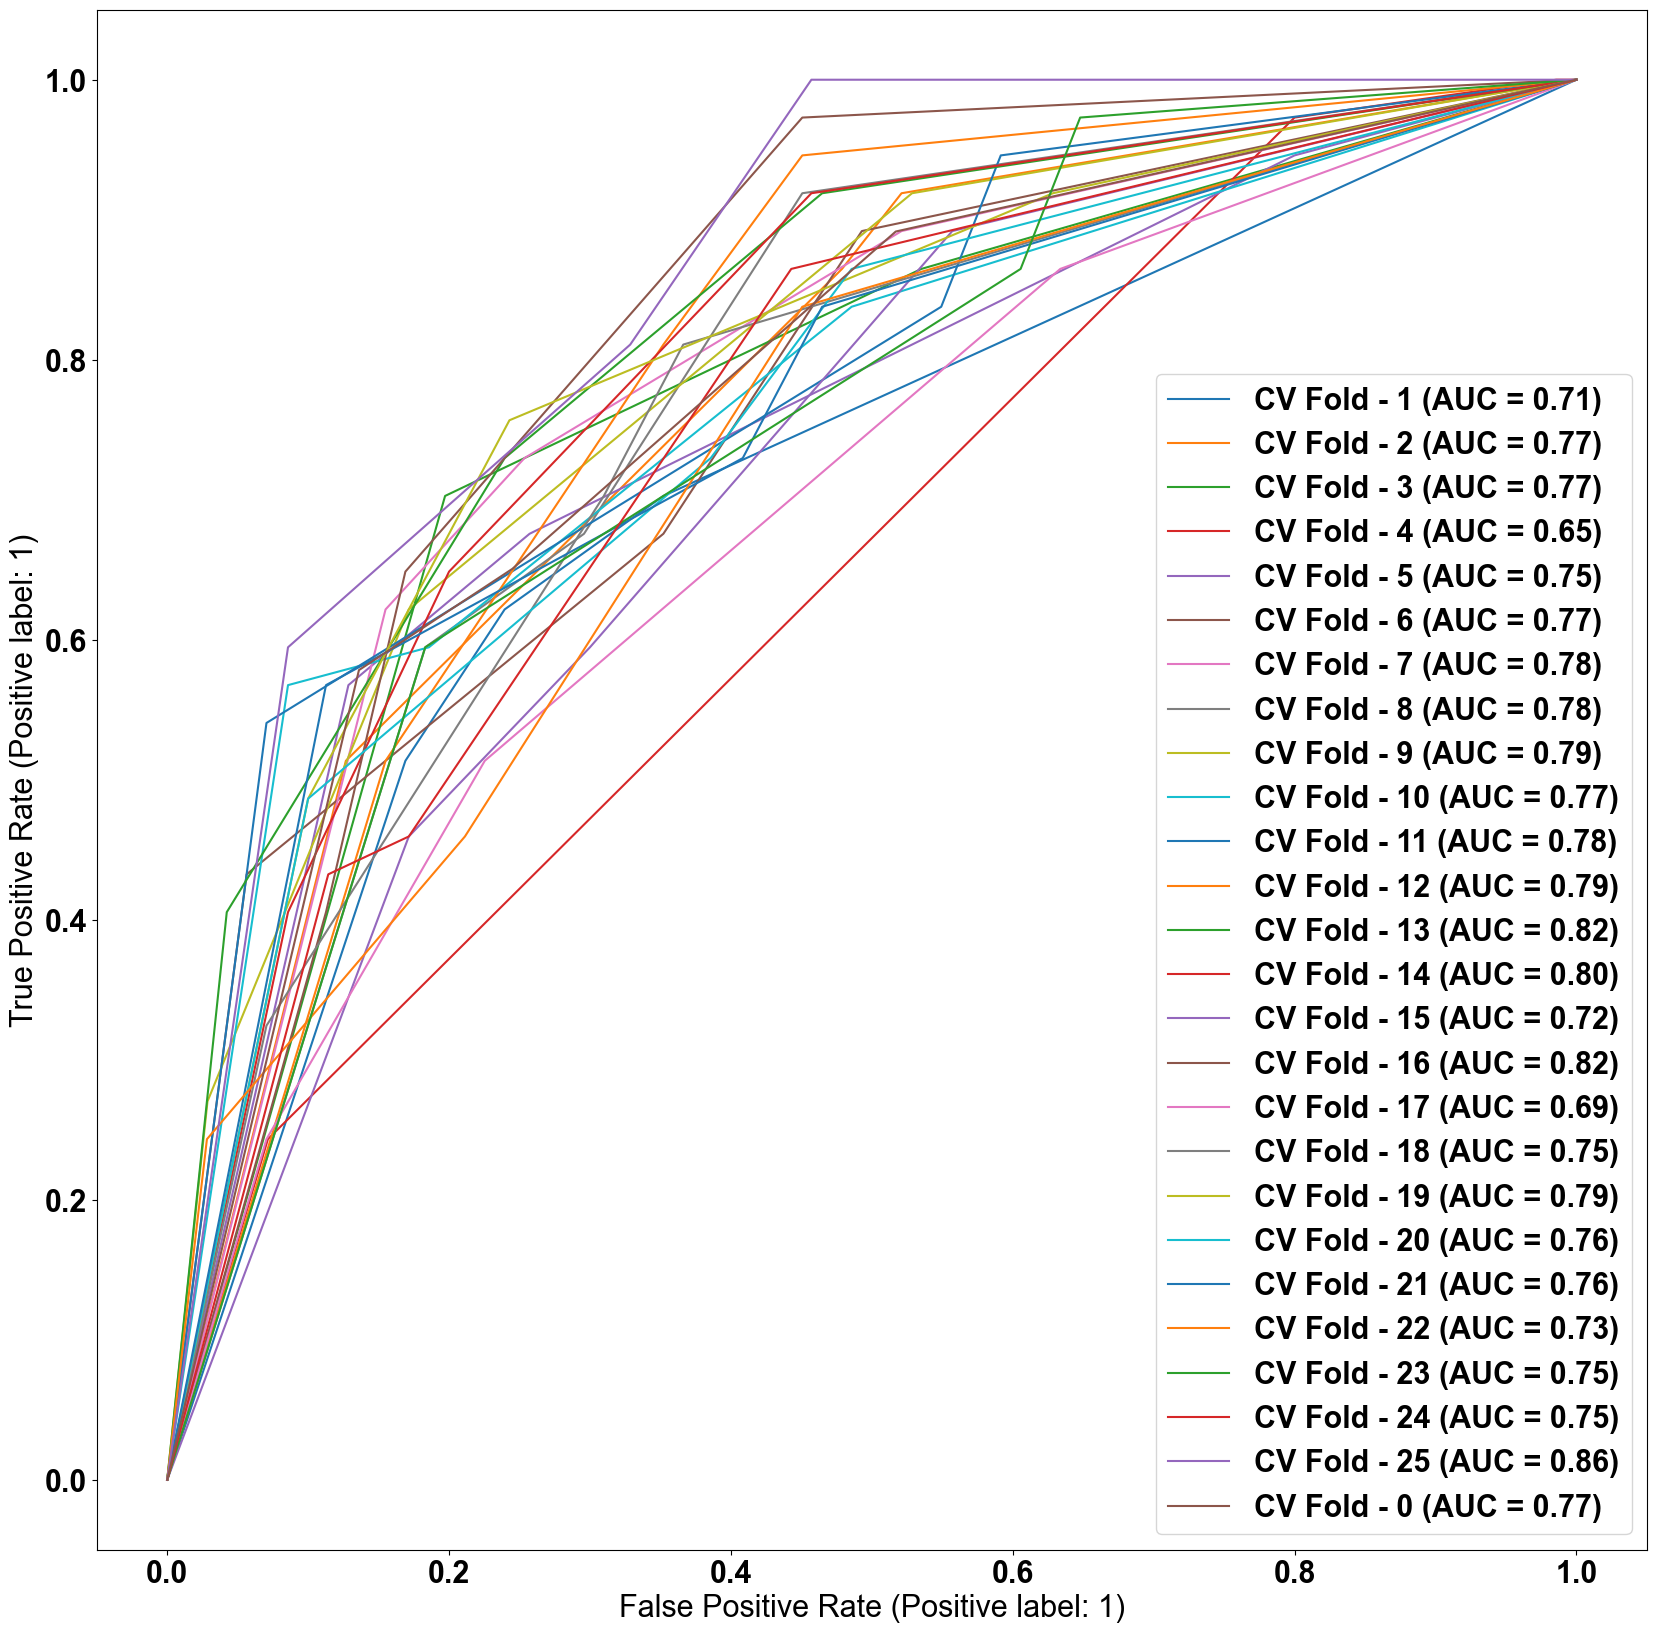

In [13]:
fig,ax=plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(20)
for val in collection_vals:
    label='CV Fold - %d'%(val['cv_fold'])
    rocDisplay = metrics.RocCurveDisplay.from_predictions(val['validation'],
                                                          val['model_probability'][:,1],
                                                          name=label,
                                                          ax=ax)
    
fig.savefig('Plots/ROC_Depth2_Entropy.svg',format='svg')

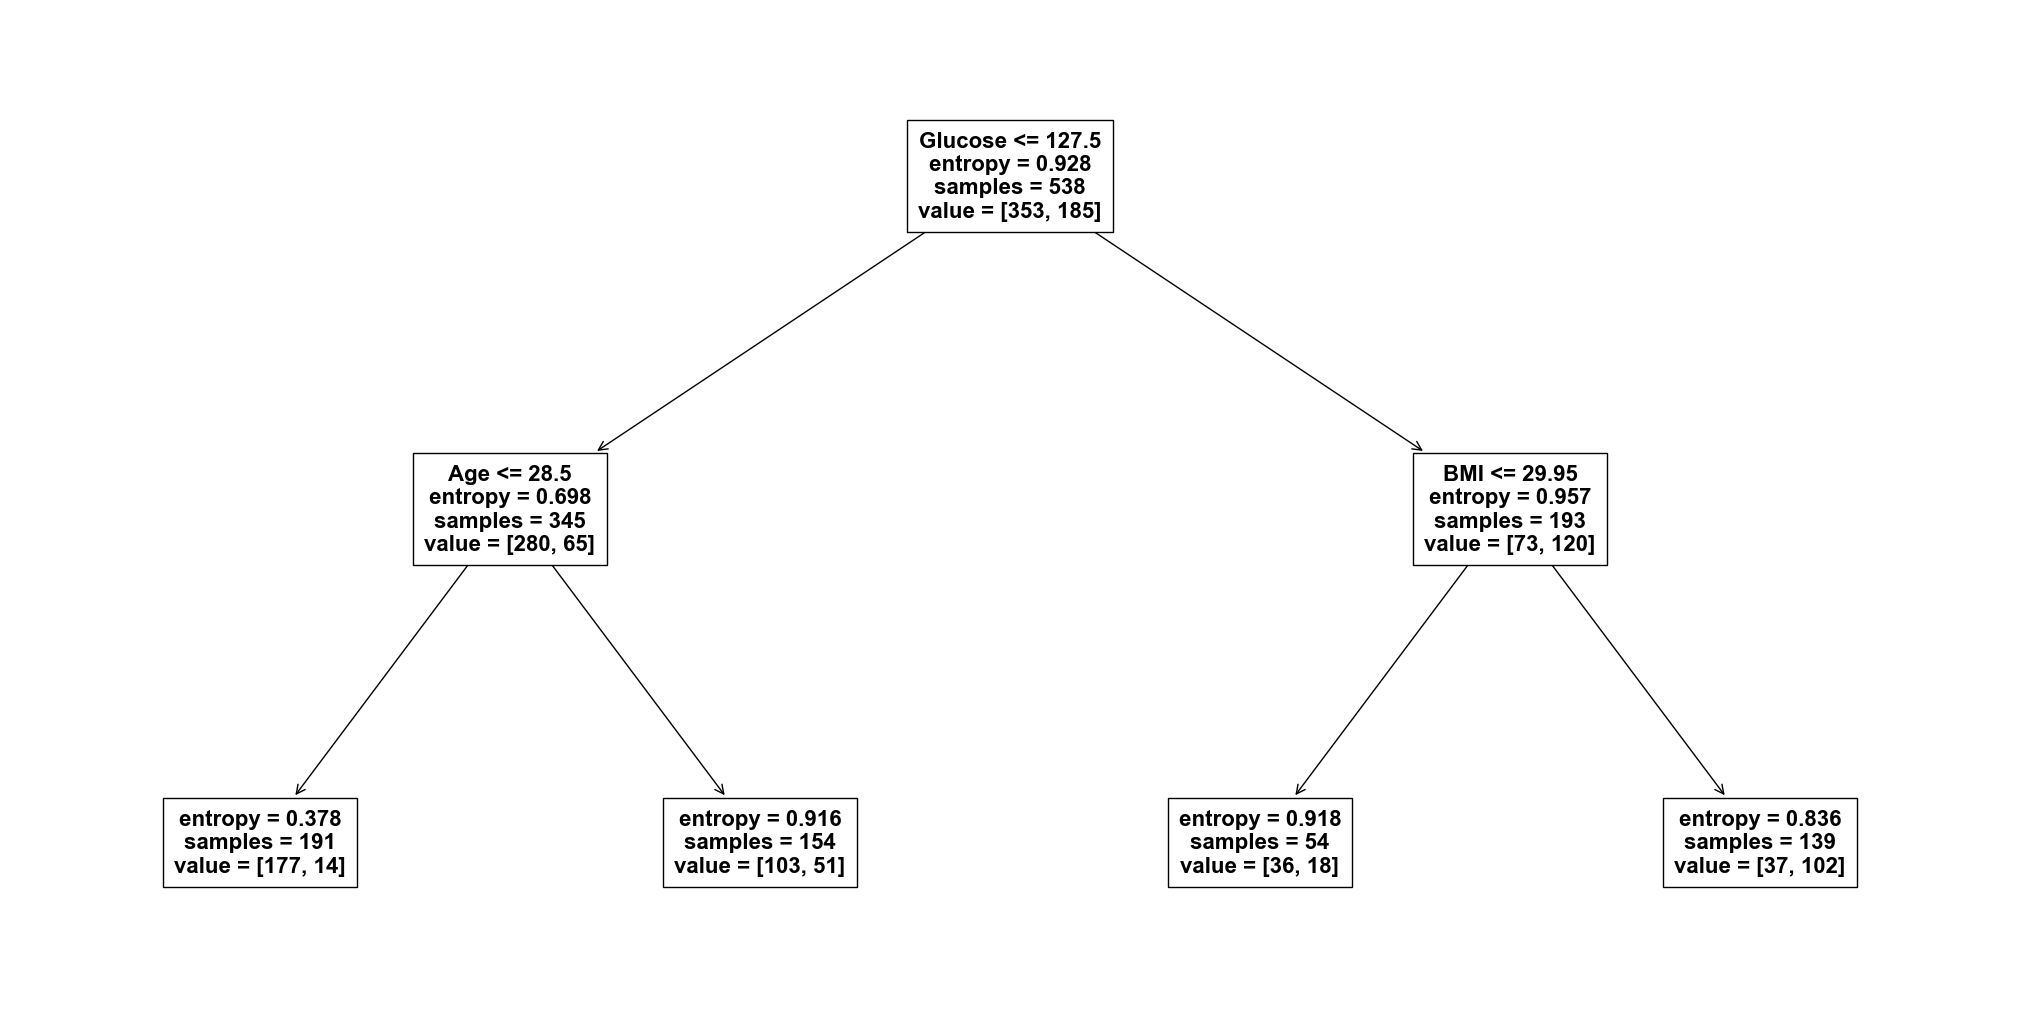

In [14]:
fig=plt.figure(figsize=[20,10])
ax=fig.add_axes([0,0,1,1])
txt=tree.plot_tree(entropy_depth2_tree,fontsize=8,proportion=False,ax=ax)
ycollect=[]
sign=1
for tx in txt:
    val = tx.get_text()
    num = re.search(r'x\[(\d+)\]',val) 
    if(num is not None): 
        num=int(num.group()[2:-1])
        tx.set_text(tx.get_text().replace(f'x[{num}]',training_data.columns[num]))
    tx.set_fontsize(16)
plt.savefig('Plots/Best_Depth2_Entropy_Metric_tree.svg',format='svg')
plt.show()

In [15]:
criterion='entropy'
depth = 4
entropy_depth4_tree = DecisionTreeClassifier(random_state=RANDOM_SEED,criterion=criterion,max_depth=depth)
scores,collection_vals = metric_statistics_decision_tree(entropy_depth4_tree,training_features,training_class,test_features,test_class,num_cv=5,num_repeat=5)
scores.to_csv('Results/Performance_Depth4_Entropy_Tree.csv',index=False)
score_summary=scores[['Accuracy','Recall','Precision','FPR','ROC_AUC']].describe().T
score_summary[['mean','std']].T

Accuracy     Recall  Precision        FPR    ROC_AUC
mean  72.900988  63.187887  61.388724  22.028029  70.579929
std    3.271747  13.995901   6.221406   9.091261   4.052070

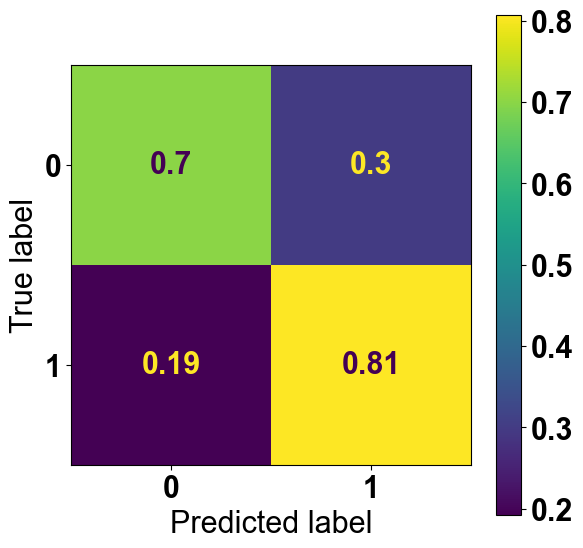

In [16]:
fig=plt.figure(figsize=[5,5])
ax = fig.add_axes([0,0,1,1])
metrics.ConfusionMatrixDisplay.from_predictions(test_class,collection_vals[-1]['model_prediction'],normalize='true',ax=ax)
plt.savefig('Plots/ConfusionMatrix_Depth4_Entropy.svg',format='svg')

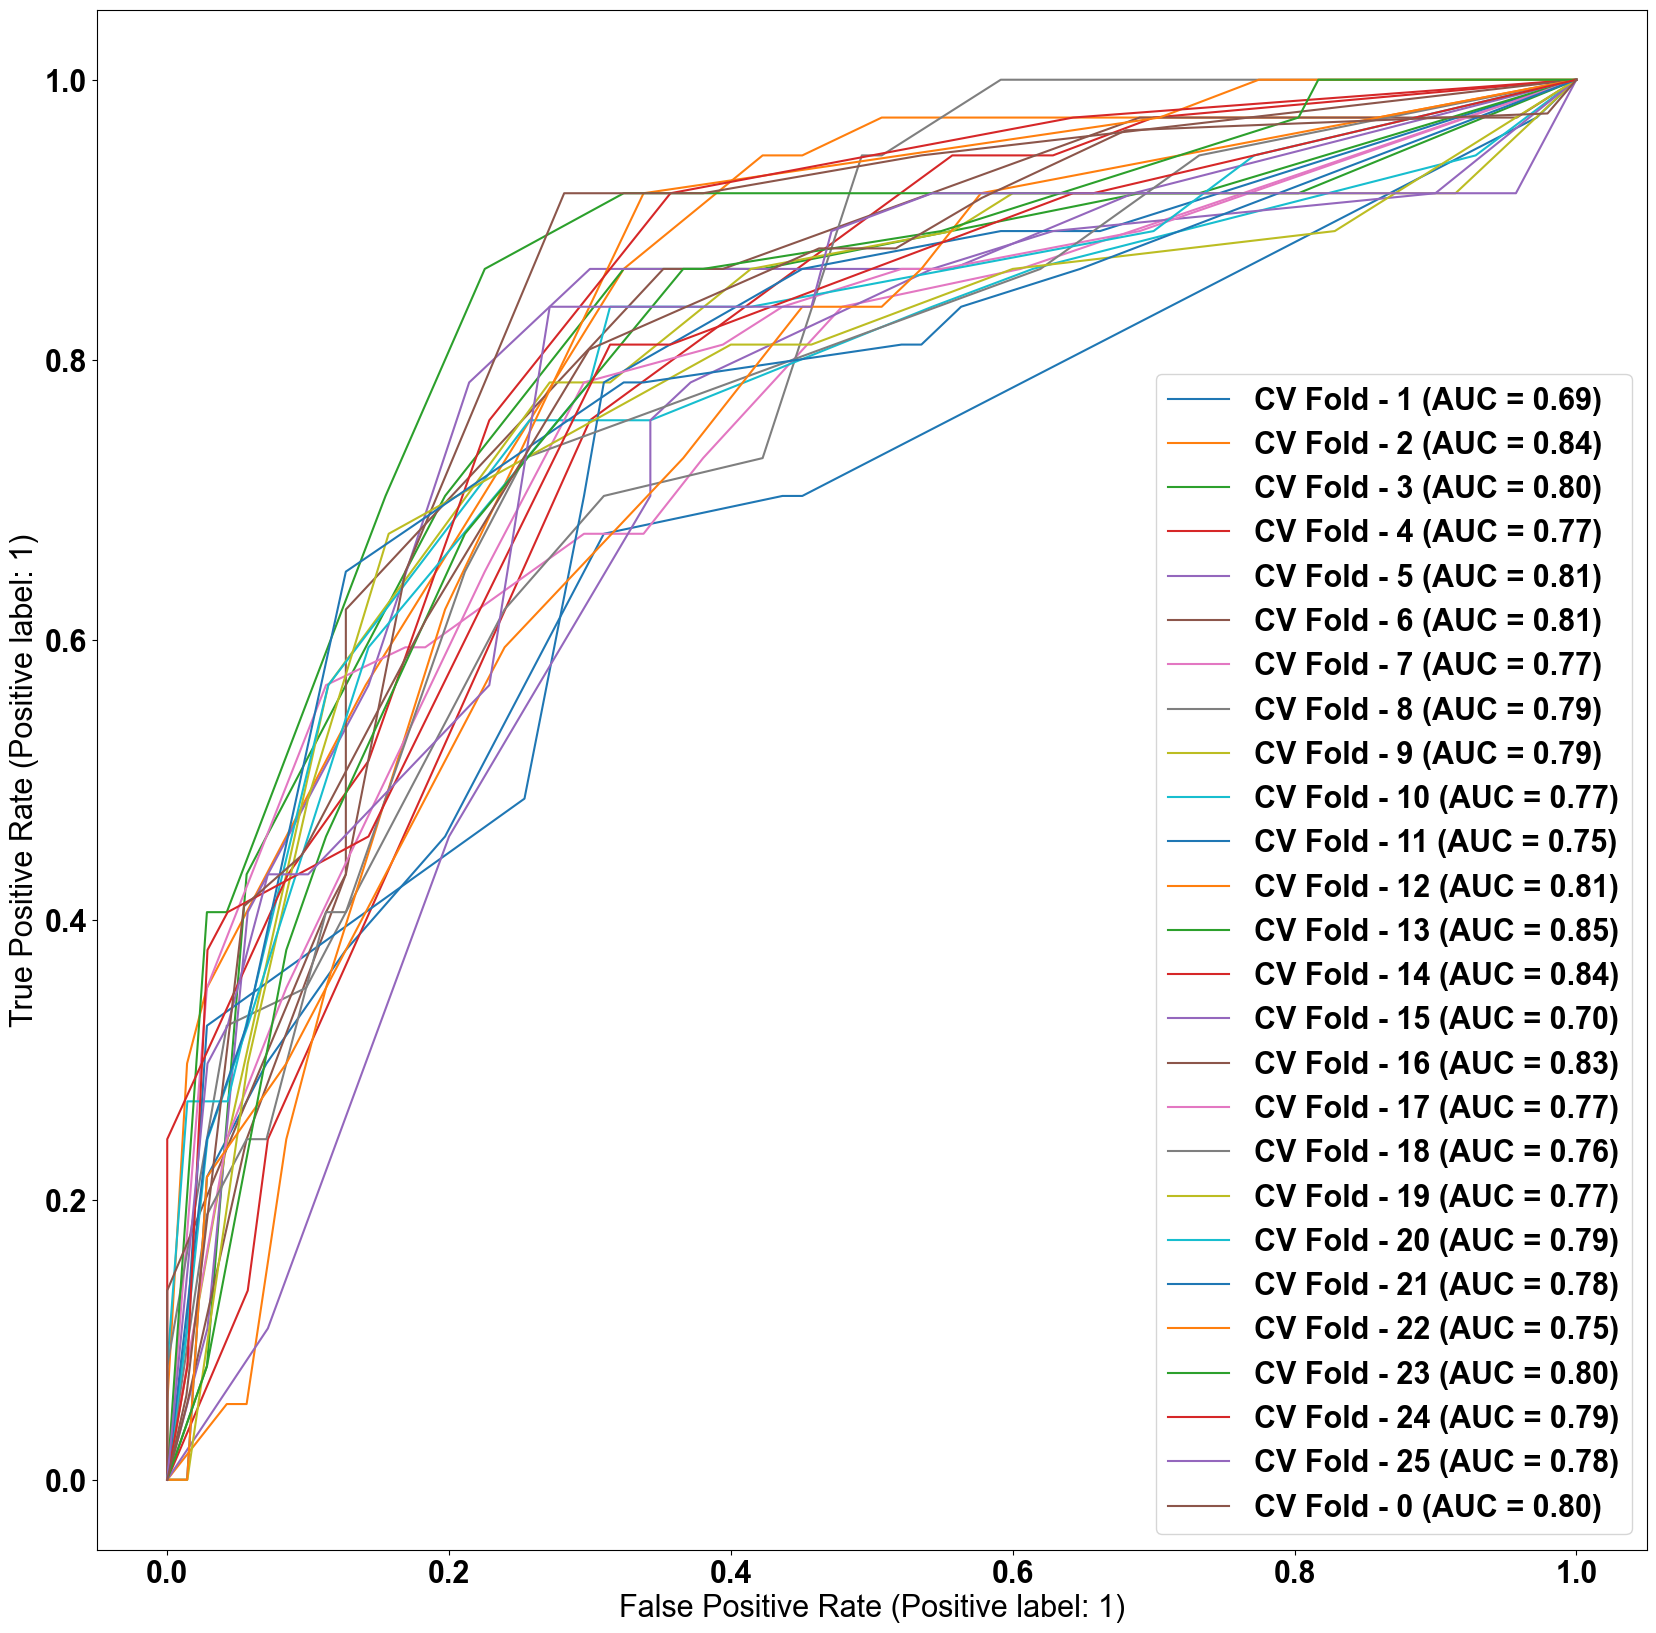

In [17]:
fig,ax=plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(20)
for val in collection_vals:
    label='CV Fold - %d'%(val['cv_fold'])
    rocDisplay = metrics.RocCurveDisplay.from_predictions(val['validation'],
                                                          val['model_probability'][:,1],
                                                          name=label,
                                                          ax=ax)
fig.savefig('Plots/ROC_Depth4_Entropy.svg',format='svg')

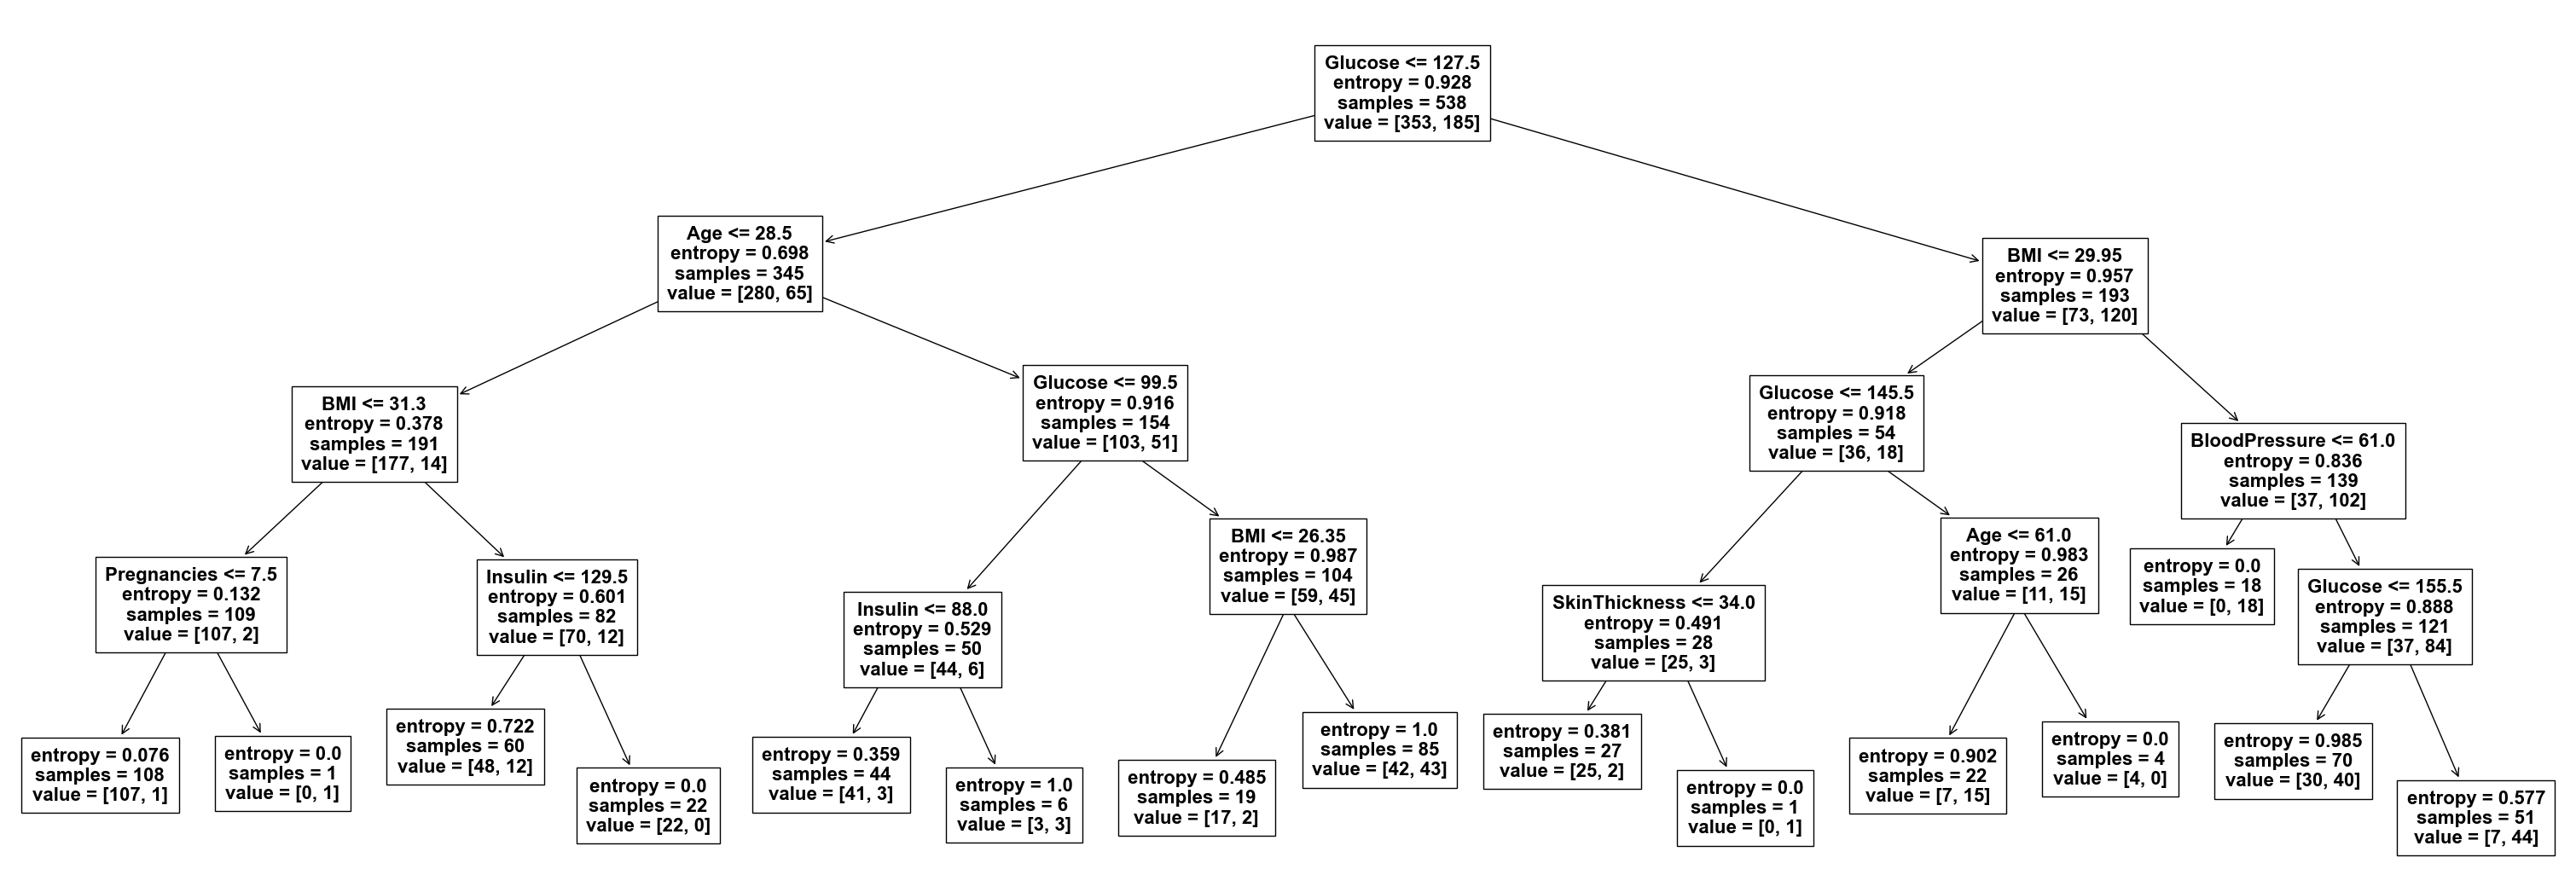

In [18]:
fig=plt.figure(figsize=[30,10])
ax=fig.add_axes([0,0,1,1])
txt=tree.plot_tree(entropy_depth4_tree,fontsize=8,proportion=False,ax=ax)
ycollect=[]
sign=1
for tx in txt:
    val = tx.get_text()
    num = re.search(r'x\[(\d+)\]',val) 
    if(num is not None): 
        num=int(num.group()[2:-1])
        tx.set_text(tx.get_text().replace(f'x[{num}]',training_data.columns[num]))
    cur_y=tx._y
    if(cur_y in ycollect):
        tx.set_y(cur_y+sign*np.random.rand()*0.05)
        sign=sign*-1
        ycollect.append(tx._y)
    else:
        ycollect.append(cur_y)
    tx.set_fontsize(16)
plt.savefig('Plots/Best_Depth4_Entropy_Metric_tree.svg',format='svg')
plt.show()

In [19]:
min_samples_leaf = 0.1313
criterion = 'entropy'
entropy_msl1313_tree = DecisionTreeClassifier(random_state=RANDOM_SEED,
                                              criterion=criterion,
                                              min_samples_leaf=min_samples_leaf)
scores,collection_vals = metric_statistics_decision_tree(entropy_msl1313_tree,training_features,training_class,test_features,test_class,num_cv=5,num_repeat=5)
scores.to_csv('Results/Performance_MSL1313_Entropy_Tree.csv',index=False)
score_summary=scores[['Accuracy','Recall','Precision','FPR','ROC_AUC']].describe().T
score_summary[['mean','std']].T

Accuracy     Recall  Precision        FPR    ROC_AUC
mean  73.332170  43.479949  70.128282  10.993802  66.243074
std    2.962174  12.711162  10.267470   7.357721   4.079930

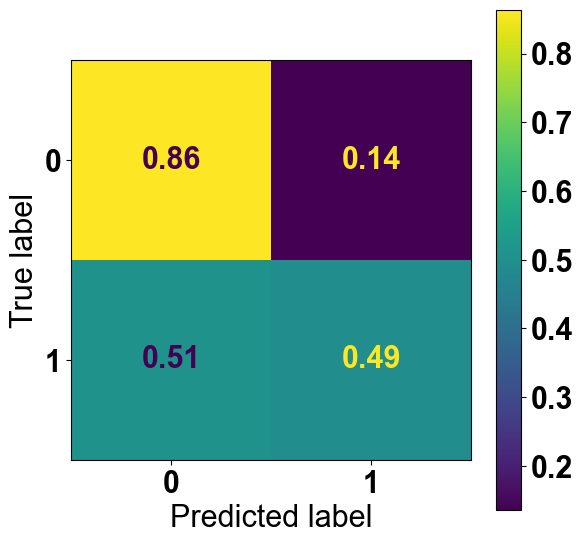

In [20]:
fig=plt.figure(figsize=[5,5])
ax = fig.add_axes([0,0,1,1])
metrics.ConfusionMatrixDisplay.from_predictions(test_class,collection_vals[-1]['model_prediction'],normalize='true',ax=ax)
plt.savefig('Plots/ConfusionMatrix_MSL1313_Entropy.svg',format='svg')

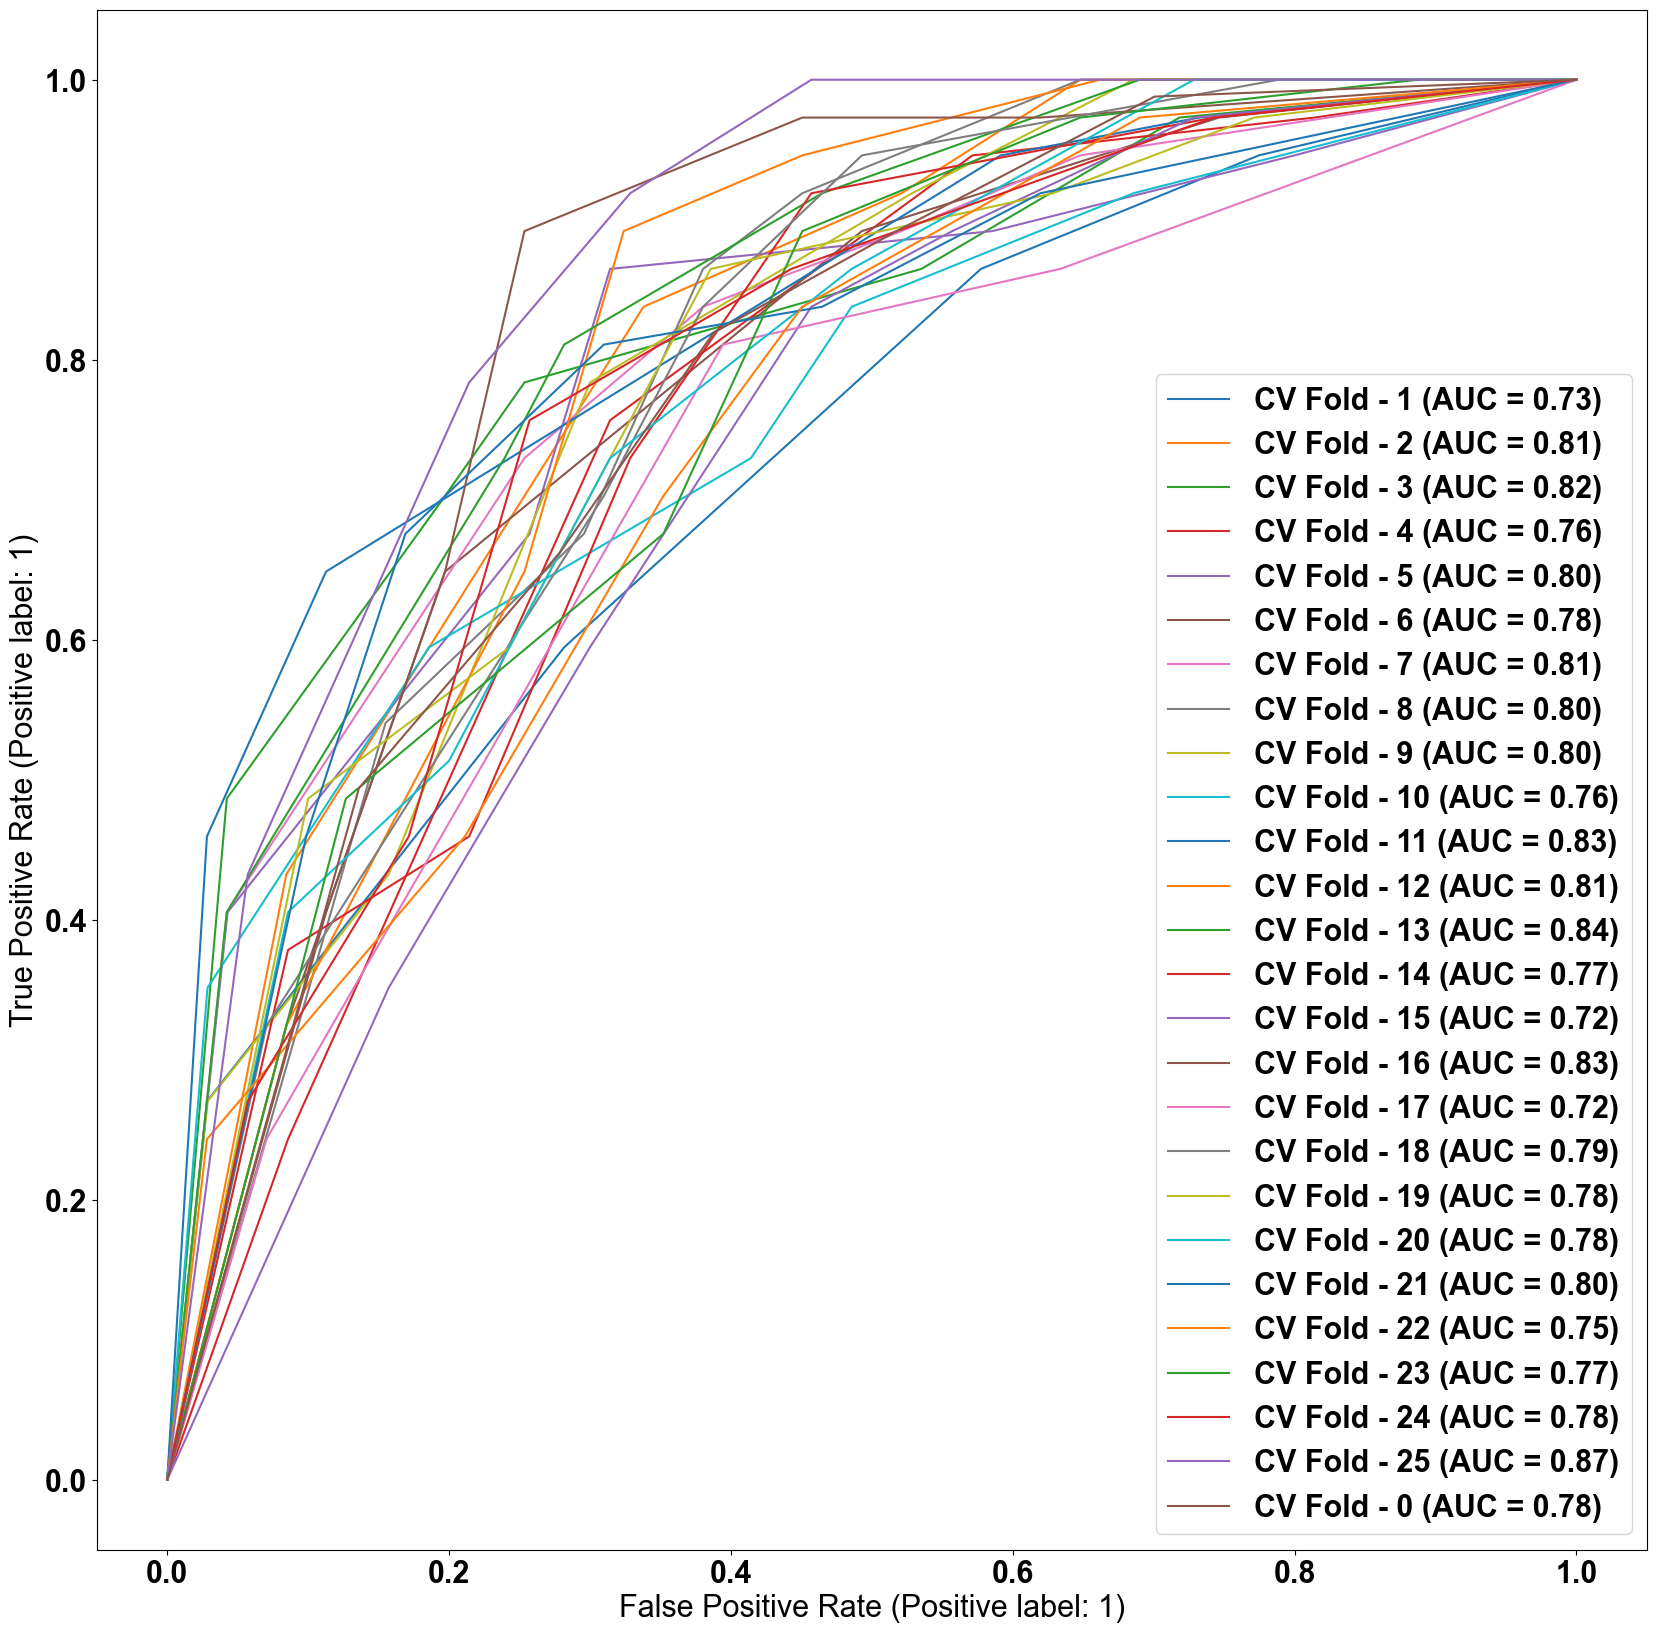

In [21]:
fig,ax=plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(20)
leg=[]
for val in collection_vals:
    label='CV Fold - %d'%(val['cv_fold'])
    rocDisplay = metrics.RocCurveDisplay.from_predictions(val['validation'],
                                                          val['model_probability'][:,1],
                                                          name=label,
                                                          ax=ax)
fig.savefig('Plots/ROC_MSL1313_Entropy.svg',format='svg')

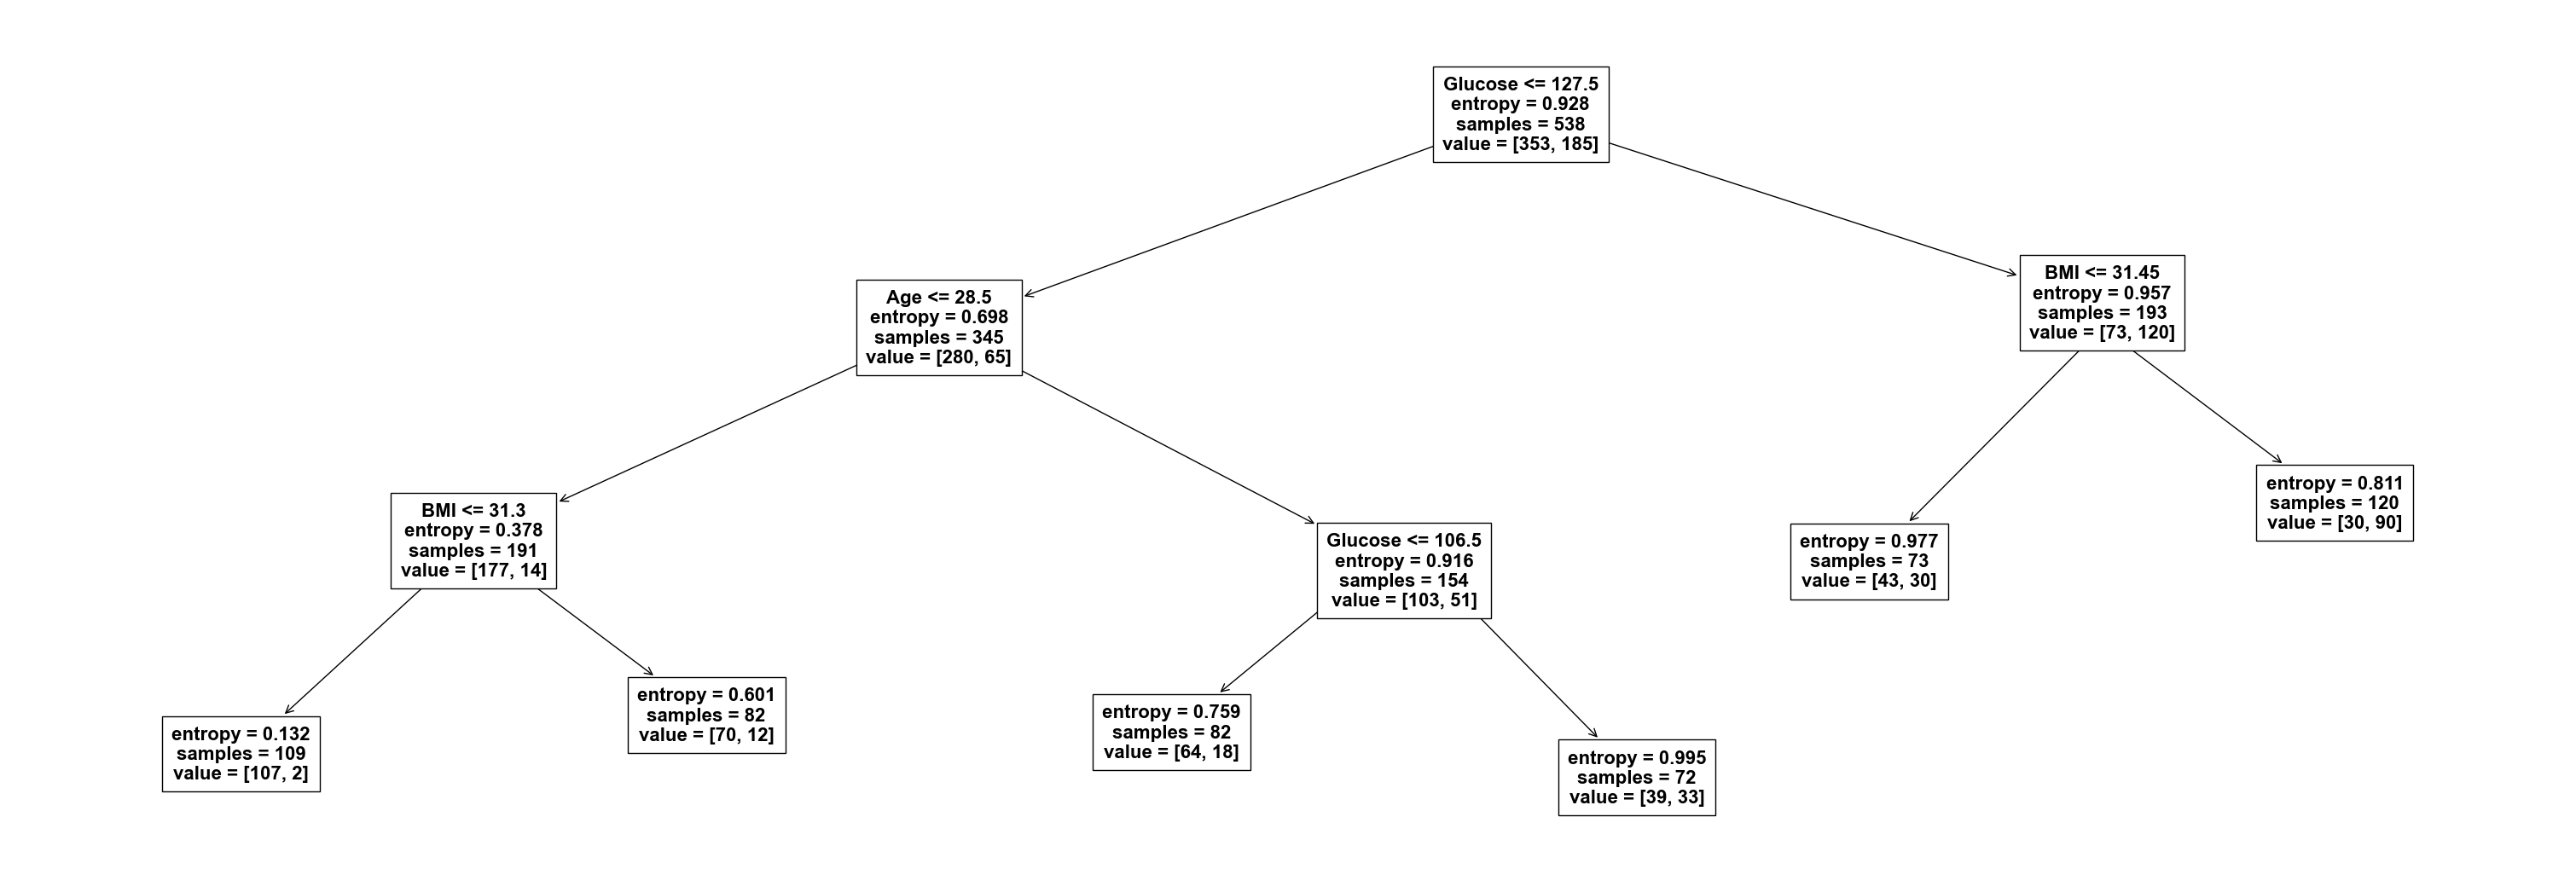

In [22]:
fig=plt.figure(figsize=[30,10])
ax=fig.add_axes([0,0,1,1])
txt=tree.plot_tree(entropy_msl1313_tree,fontsize=8,proportion=False,ax=ax)
ycollect=[]
sign=1
for tx in txt:
    val = tx.get_text()
    num = re.search(r'x\[(\d+)\]',val) 
    if(num is not None): 
        num=int(num.group()[2:-1])
        tx.set_text(tx.get_text().replace(f'x[{num}]',training_data.columns[num]))
    cur_y=tx._y
    if(cur_y in ycollect):
        tx.set_y(cur_y+sign*np.random.rand()*0.05)
        sign=sign*-1
        ycollect.append(tx._y)
    else:
        ycollect.append(cur_y)
    tx.set_fontsize(16)
plt.savefig('Plots/Best_MSL1313_Entropy_Metric_tree.svg',format='svg')
plt.show()

In [23]:
min_samples_leaf = 0.3022
criterion = 'entropy'
entropy_msl3022_tree = DecisionTreeClassifier(random_state=RANDOM_SEED,
                                              criterion=criterion,
                                              min_samples_leaf=min_samples_leaf)

scores,collection_vals = metric_statistics_decision_tree(entropy_msl3022_tree,training_features,training_class,test_features,test_class,num_cv=5,num_repeat=5)
scores.to_csv('Results/Performance_MSL3022_Entropy_Tree.csv',index=False)
score_summary=scores[['Accuracy','Recall','Precision','FPR','ROC_AUC']].describe().T
score_summary[['mean','std']].T

Accuracy     Recall  Precision        FPR    ROC_AUC
mean  73.392169  64.560529  60.922209  21.968846  71.295841
std    3.712284   8.174066   5.540891   4.750484   4.249424

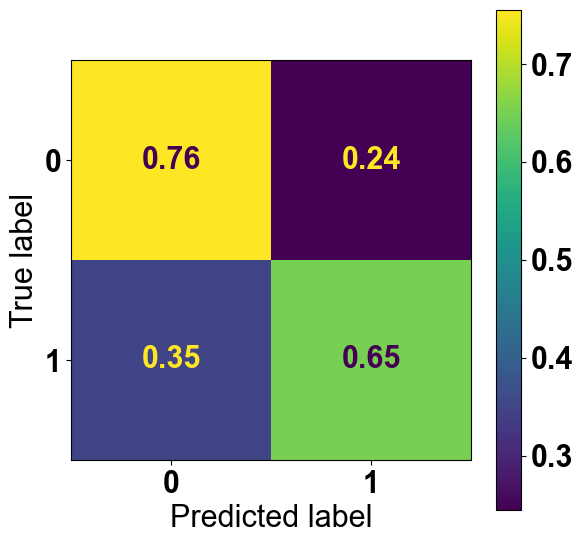

In [24]:
fig=plt.figure(figsize=[5,5])
ax = fig.add_axes([0,0,1,1])
metrics.ConfusionMatrixDisplay.from_predictions(test_class,collection_vals[-1]['model_prediction'],normalize='true',ax=ax)
plt.savefig('Plots/ConfusionMatrix_MSL3022_Entropy.svg',format='svg')

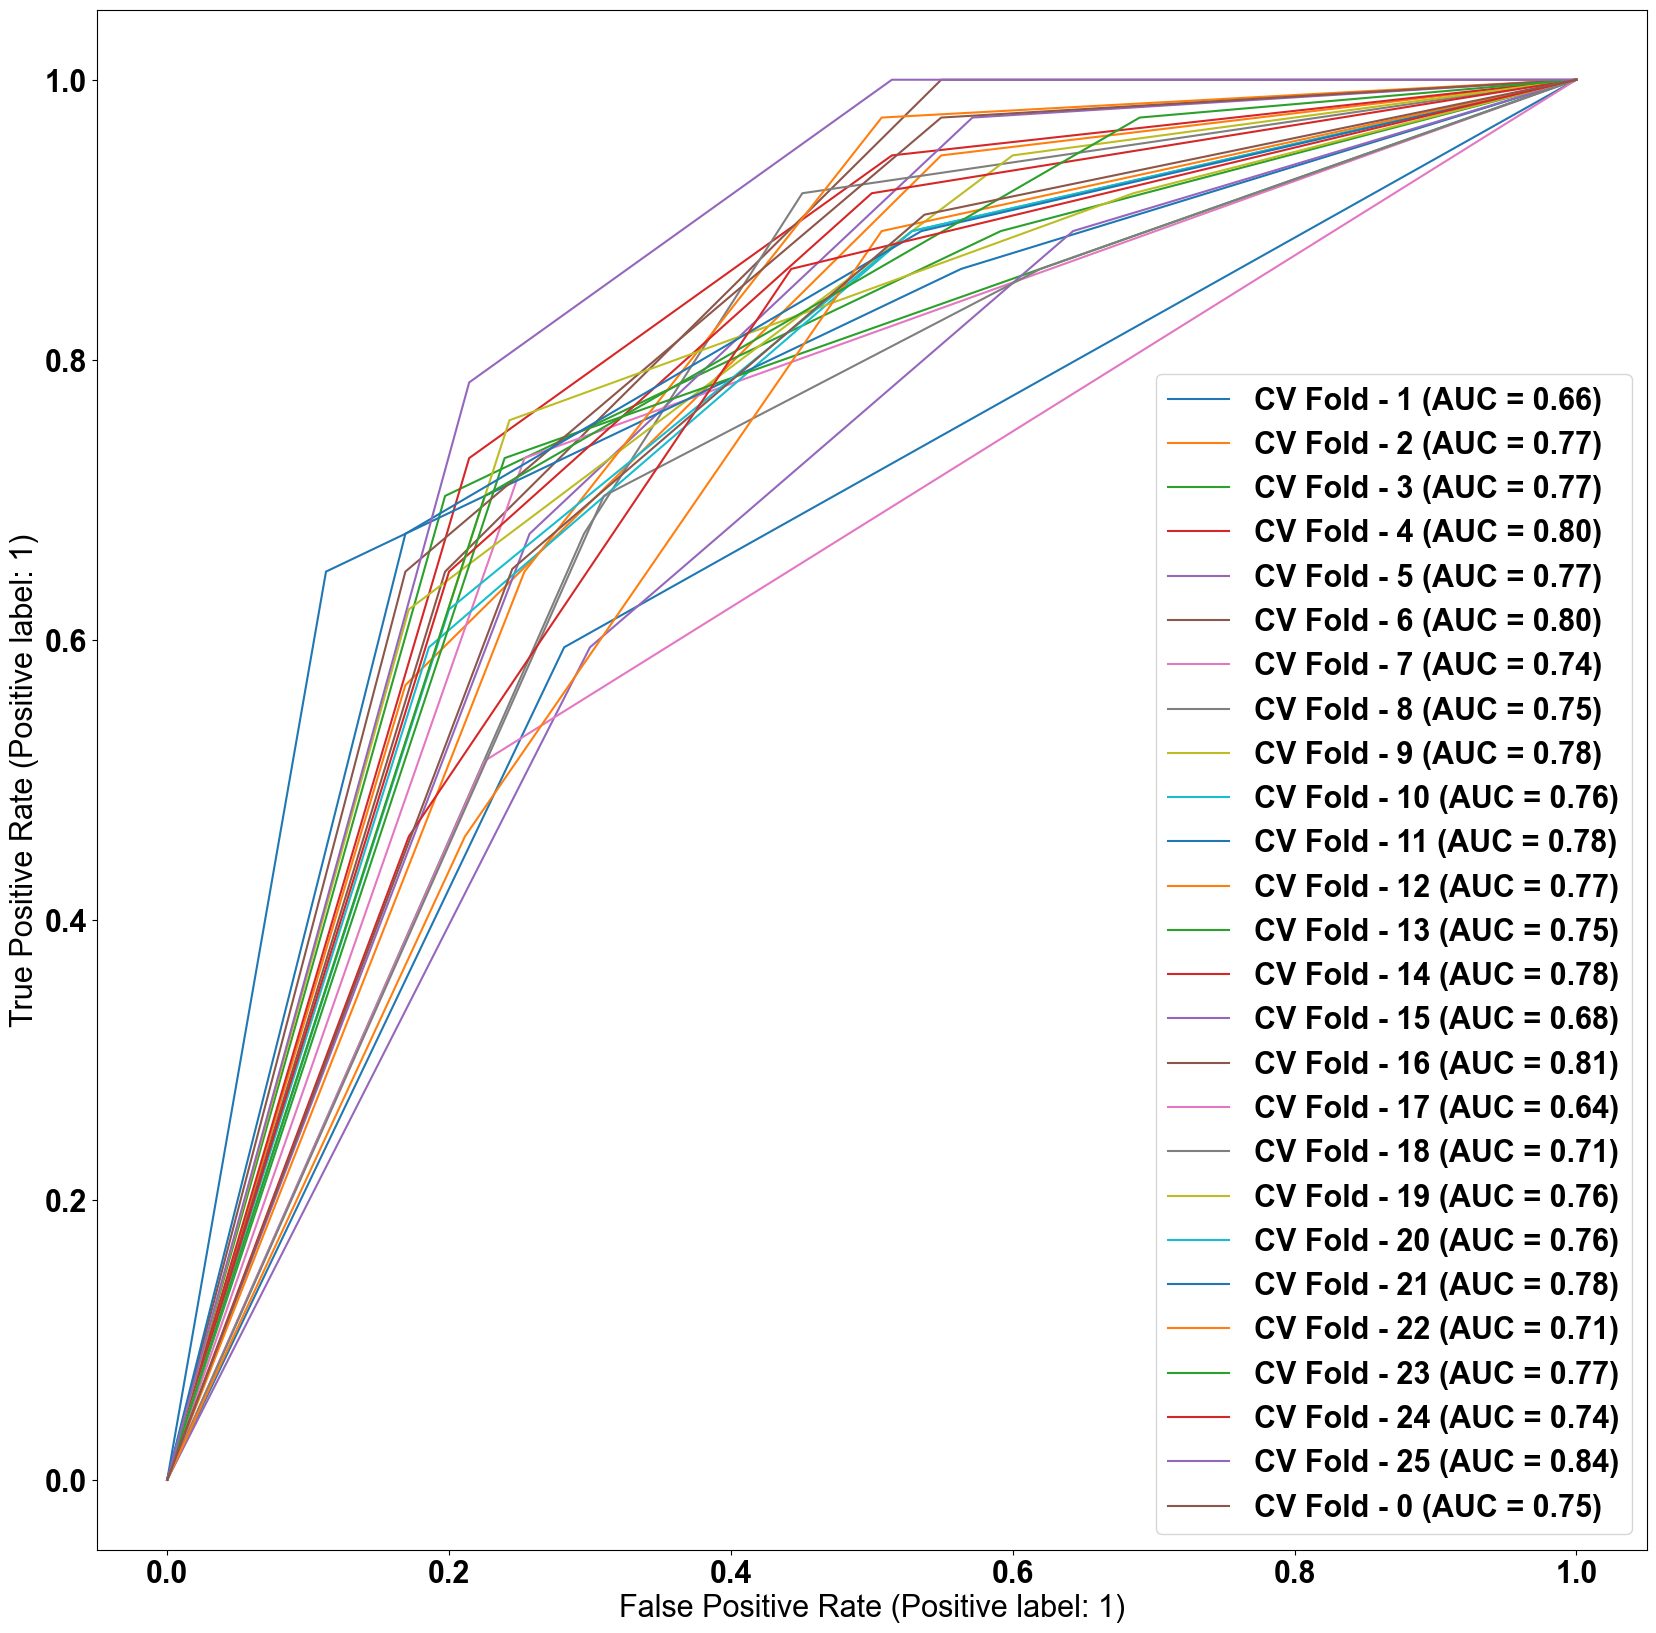

In [25]:
fig,ax=plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(20)
leg=[]
for val in collection_vals:
    label='CV Fold - %d'%(val['cv_fold'])
    rocDisplay = metrics.RocCurveDisplay.from_predictions(val['validation'],
                                                          val['model_probability'][:,1],
                                                          name=label,
                                                          ax=ax)
fig.savefig('Plots/ROC_MSL3022_Entropy.svg',format='svg')

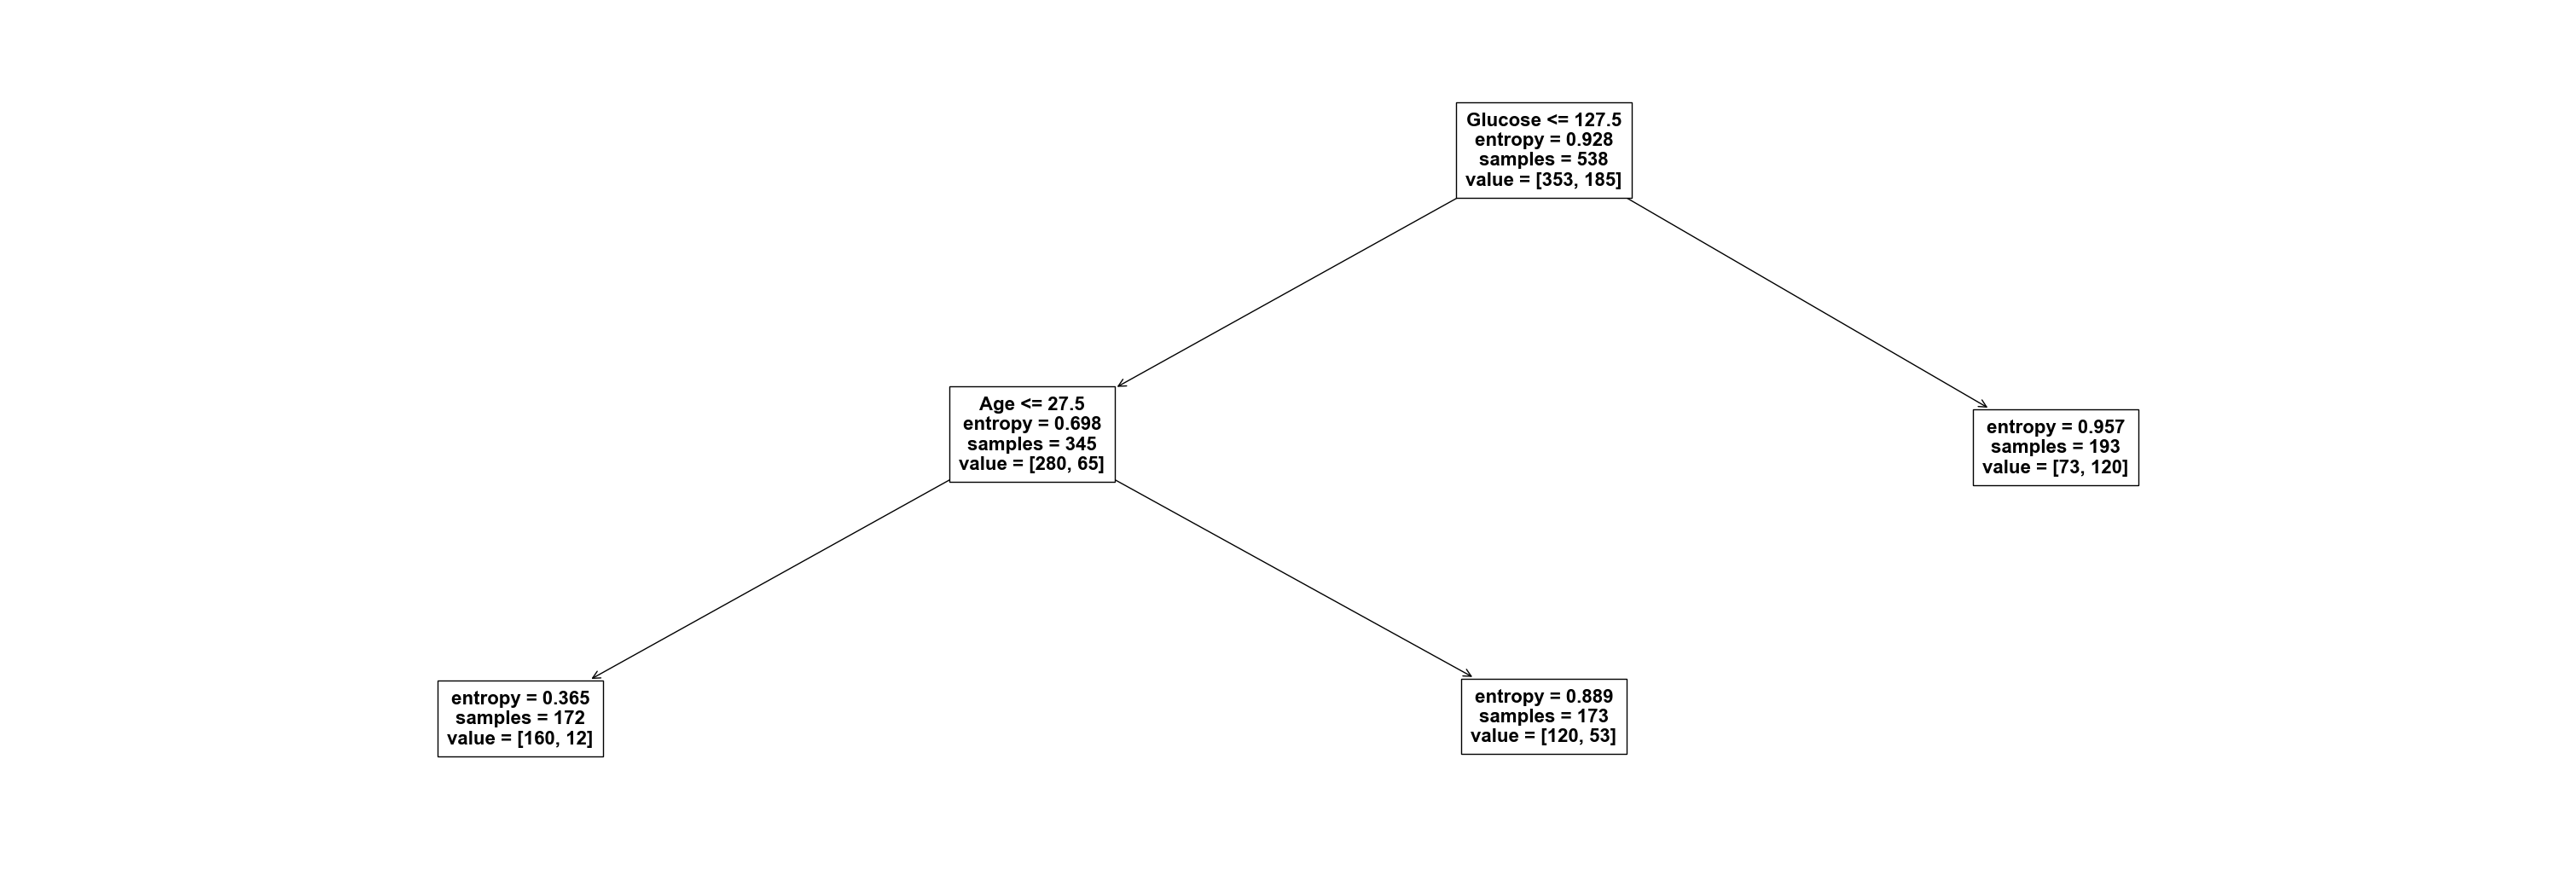

In [26]:
fig=plt.figure(figsize=[30,10])
ax=fig.add_axes([0,0,1,1])
txt=tree.plot_tree(entropy_msl3022_tree,fontsize=8,proportion=False,ax=ax)
ycollect=[]
sign=1
for tx in txt:
    val = tx.get_text()
    num = re.search(r'x\[(\d+)\]',val) 
    if(num is not None): 
        num=int(num.group()[2:-1])
        tx.set_text(tx.get_text().replace(f'x[{num}]',training_data.columns[num]))
    cur_y=tx._y
    if(cur_y in ycollect):
        tx.set_y(cur_y+sign*np.random.rand()*0.05)
        sign=sign*-1
        ycollect.append(tx._y)
    else:
        ycollect.append(cur_y)
    tx.set_fontsize(16)
plt.savefig('Plots/Best_MSL3022_Entropy_Metric_tree.svg',format='svg')
plt.show()

In [125]:
criterion = 'entropy'
metrics_collect = []
raw_stuff_msl_collect = []
for min_samples_leaf in np.linspace(0.001,0.4,50): 
    
    dtree = DecisionTreeClassifier(random_state=RANDOM_SEED,
                                   criterion=criterion,
                                   min_samples_leaf=min_samples_leaf)
    df,raw_stuff = metric_statistics_decision_tree(dtree,training_features,training_class,test_features,test_class)
    df['MSL'] = min_samples_leaf
    metrics_collect.append(df)
    raw_stuff_msl_collect.append(raw_stuff)

scores_msl=pd.concat(metrics_collect)


metrics_collect = []
raw_stuff_depth_collect = []
for depth in range(1,20):
    
    dtree = DecisionTreeClassifier(random_state=RANDOM_SEED,
                                   criterion=criterion,
                                   max_depth=depth)
    df,raw_stuff = metric_statistics_decision_tree(dtree,training_features,training_class,test_features,test_class)
    df['Depth'] = depth
    metrics_collect.append(df)
    raw_stuff_depth_collect.append(raw_stuff)

scores_depth=pd.concat(metrics_collect)


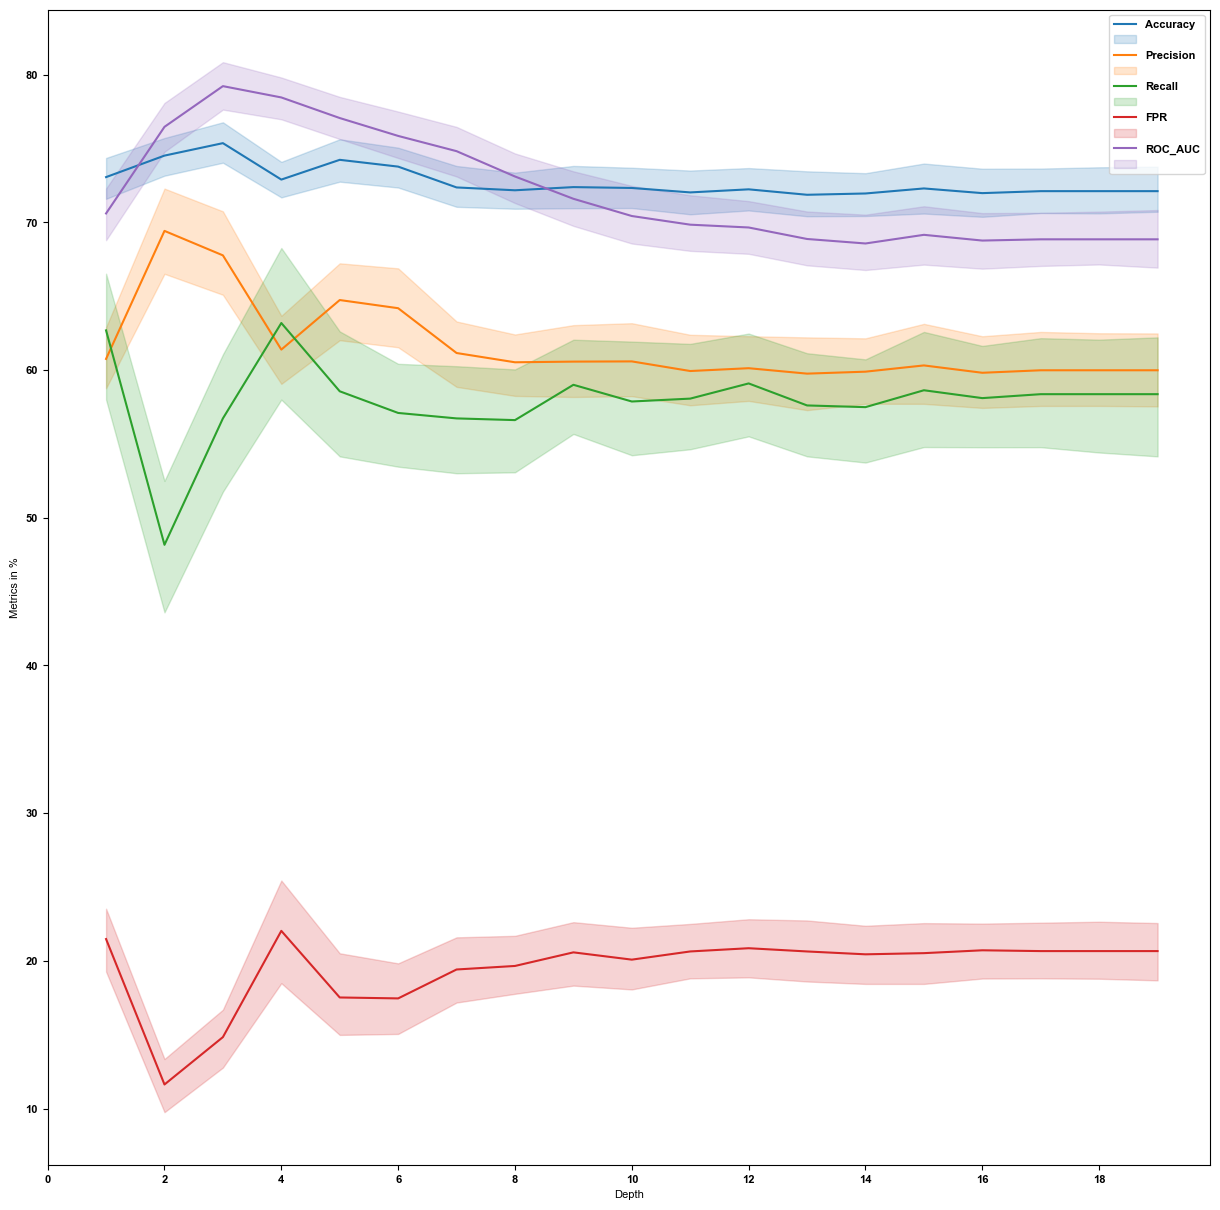

In [118]:
fig = plt.figure(figsize=[15,15])
sns.lineplot(data=scores_depth,x='Depth',y='Accuracy')
sns.lineplot(data=scores_depth,x='Depth',y='Precision')
sns.lineplot(data=scores_depth,x='Depth',y='Recall')
sns.lineplot(data=scores_depth,x='Depth',y='FPR')
sns.lineplot(data=scores_depth,x='Depth',y='ROC_AUC')
plt.legend(['Accuracy','','Precision','','Recall','','FPR','','ROC_AUC',''])
plt.ylabel('Metrics in %')
plt.xticks(range(0,20,2))
plt.show()
plt.close()

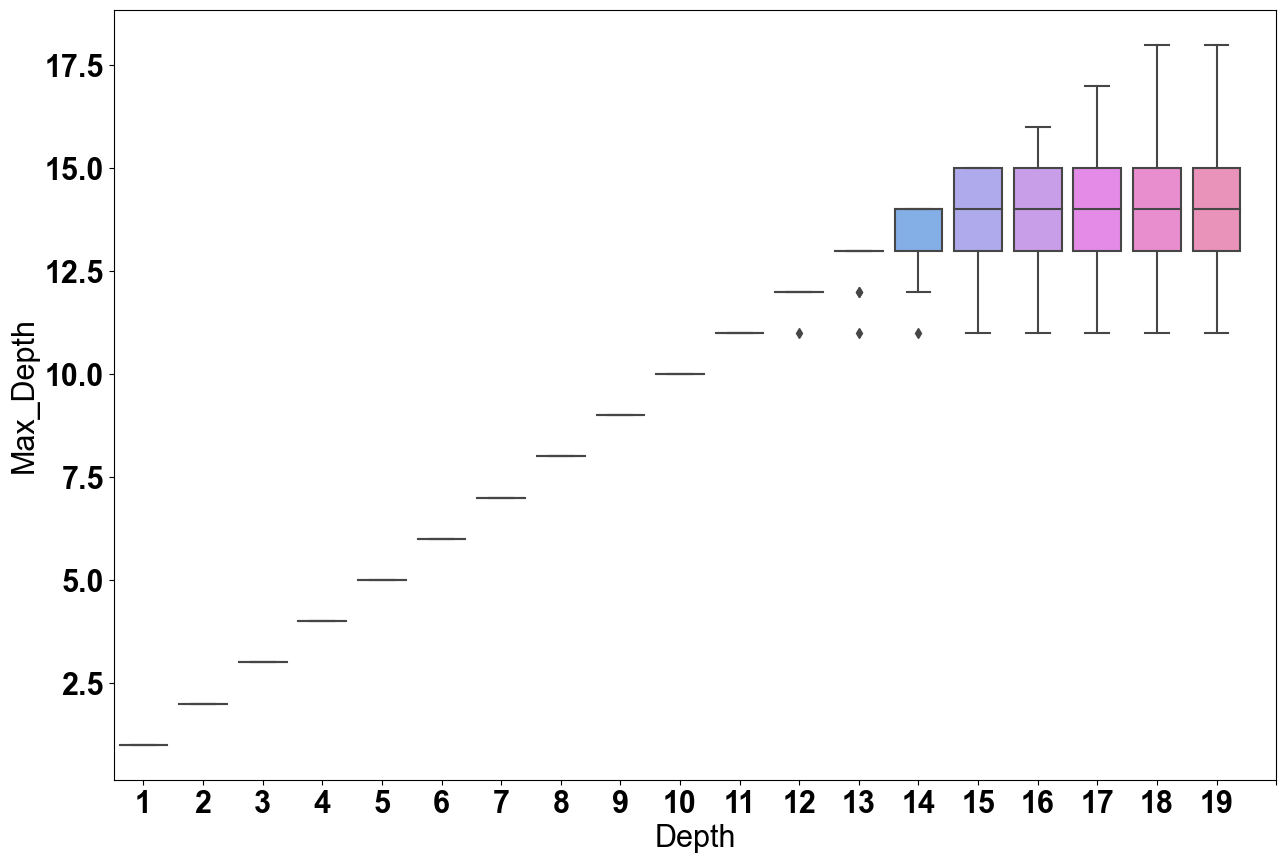

In [87]:
fig = plt.figure(figsize=[15,10])
sns.boxplot(data=scores_depth,x='Depth',y='Max_Depth')
plt.xticks(range(0,20,1))
plt.show()
plt.close()

(390, 8) (494, 8)


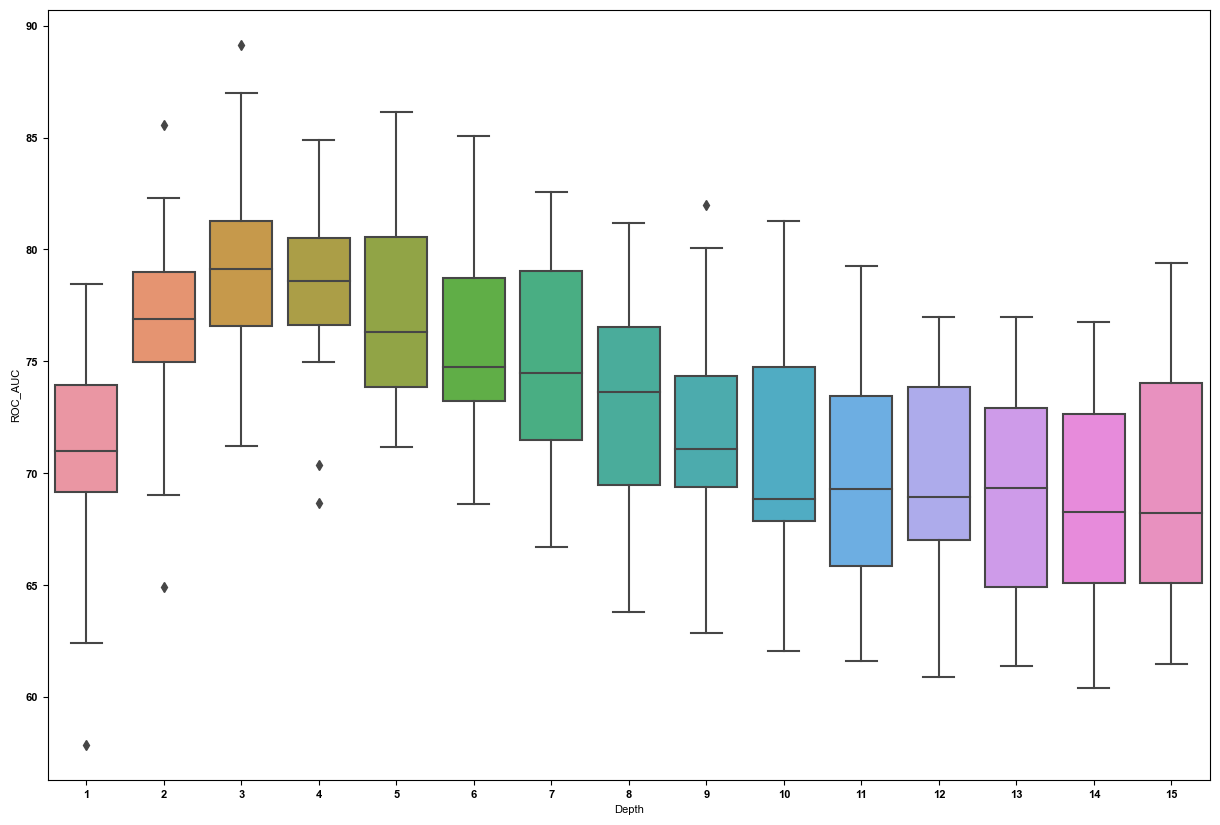

In [119]:
loc = scores_depth.Depth<=15
fig = plt.figure(figsize=[15,10])
filt_df = scores_depth.loc[loc,:].copy()
print(filt_df.shape,scores_depth.shape)
sns.boxplot(data=filt_df,x='Depth',y='ROC_AUC')
plt.xticks(range(0,15,1))
plt.show()
plt.close()


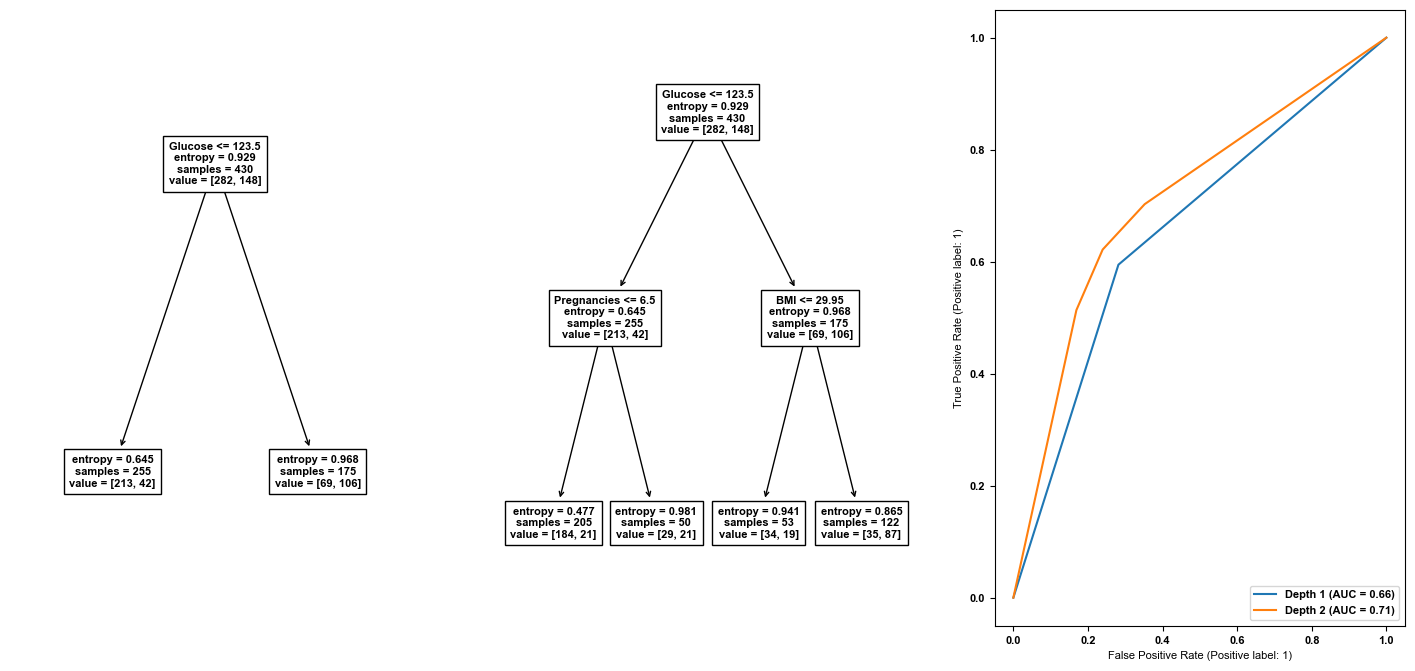

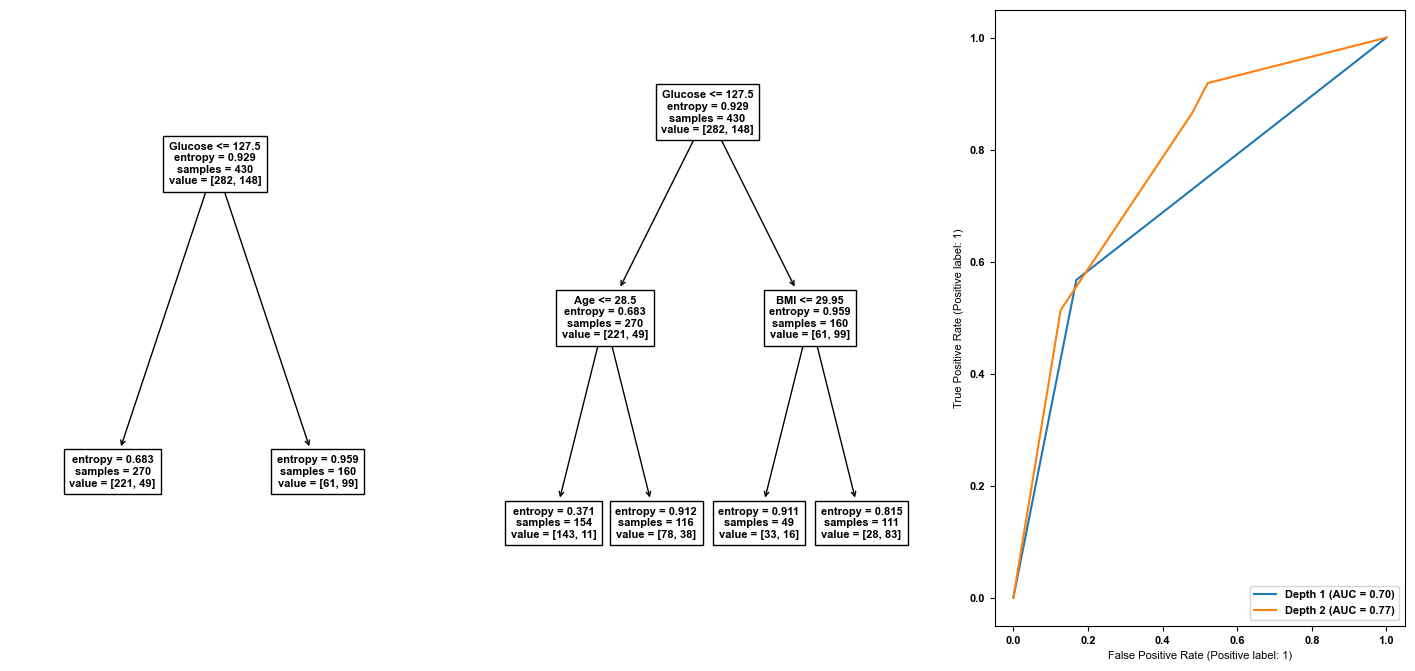

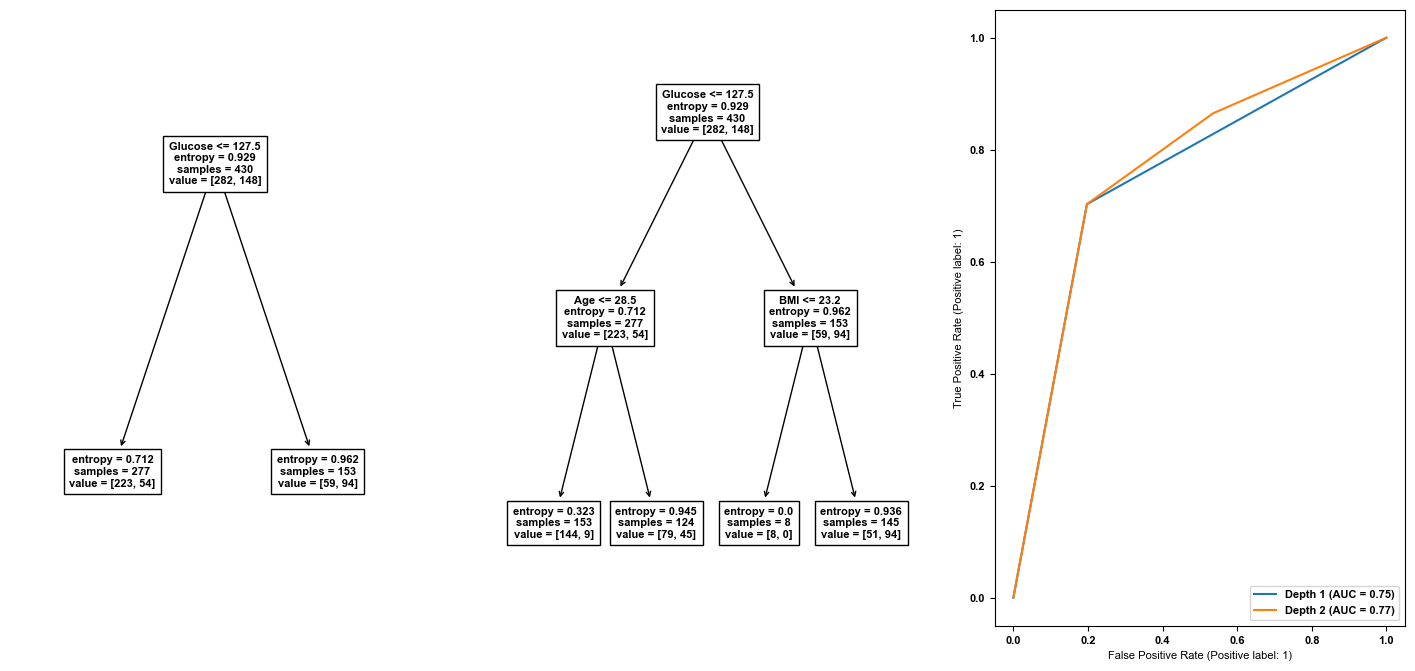

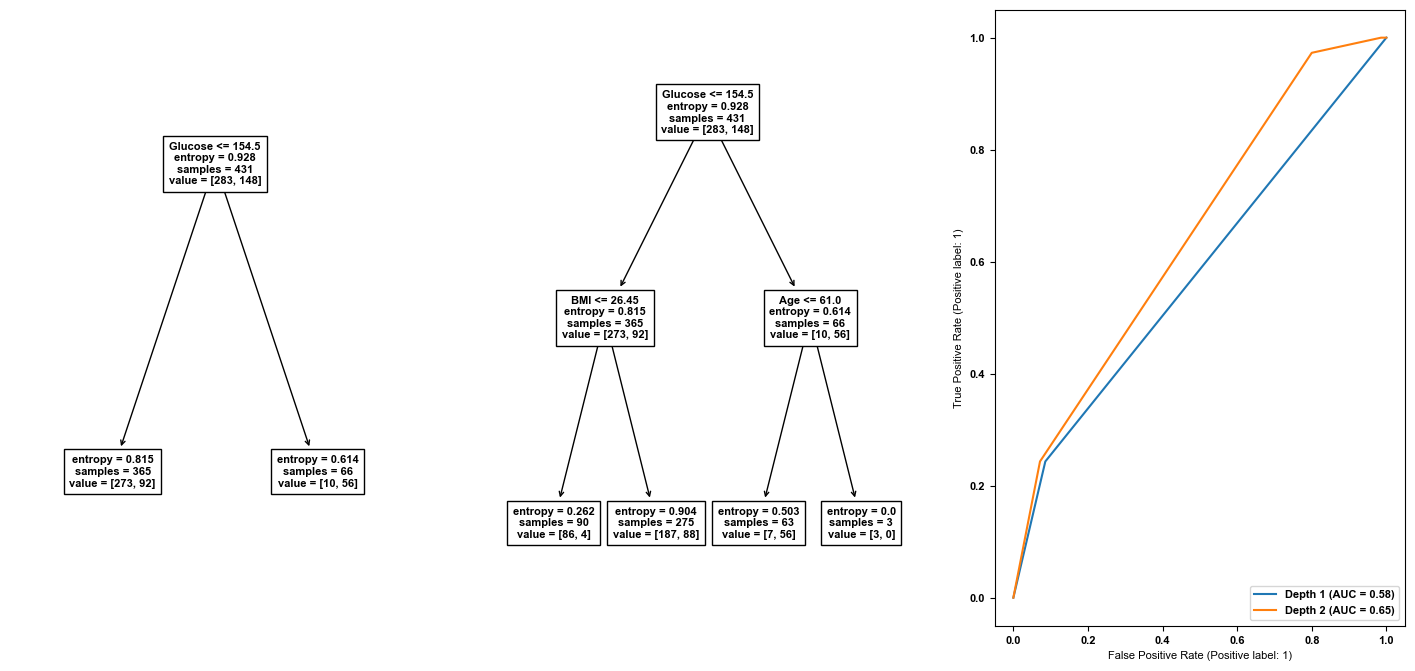

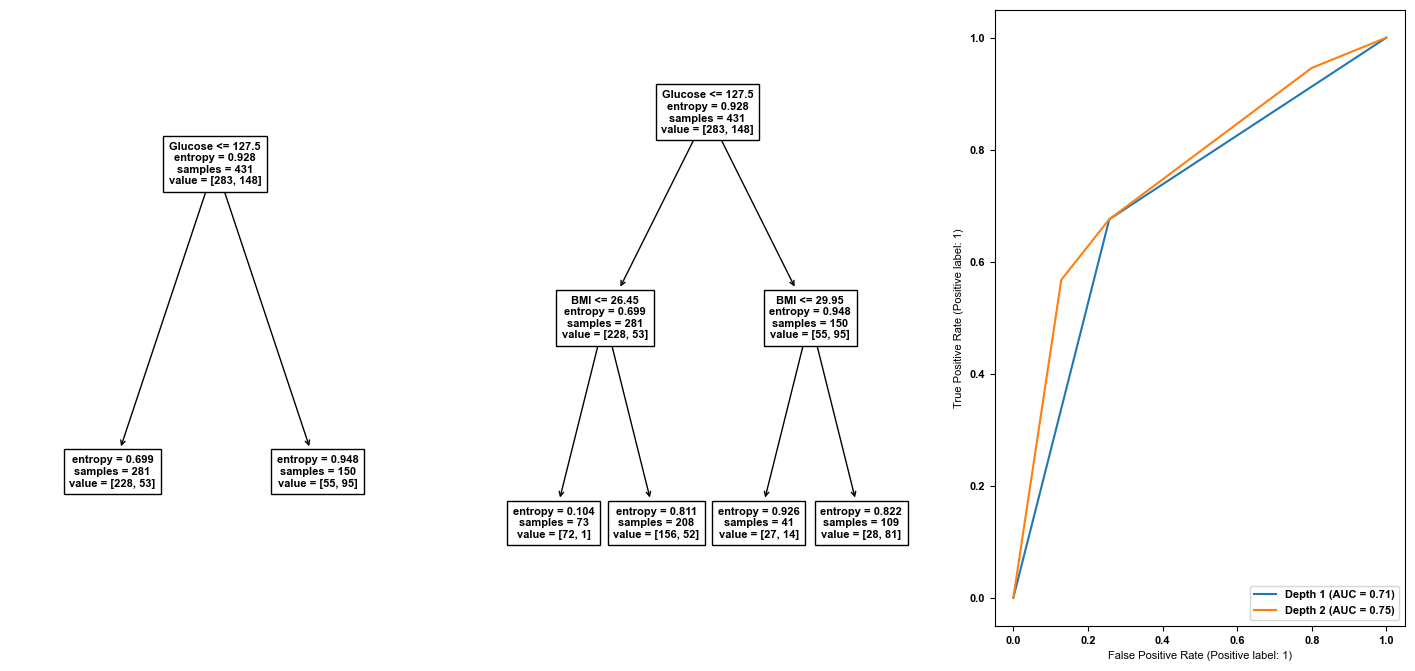

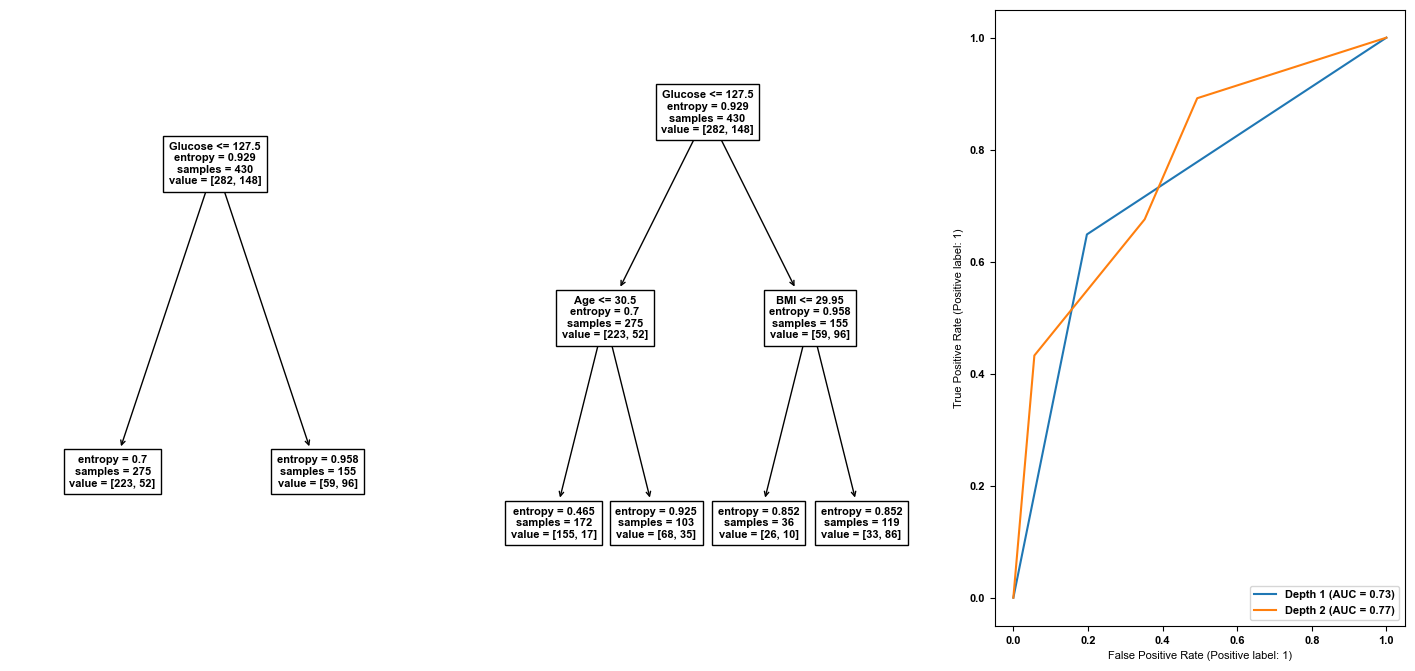

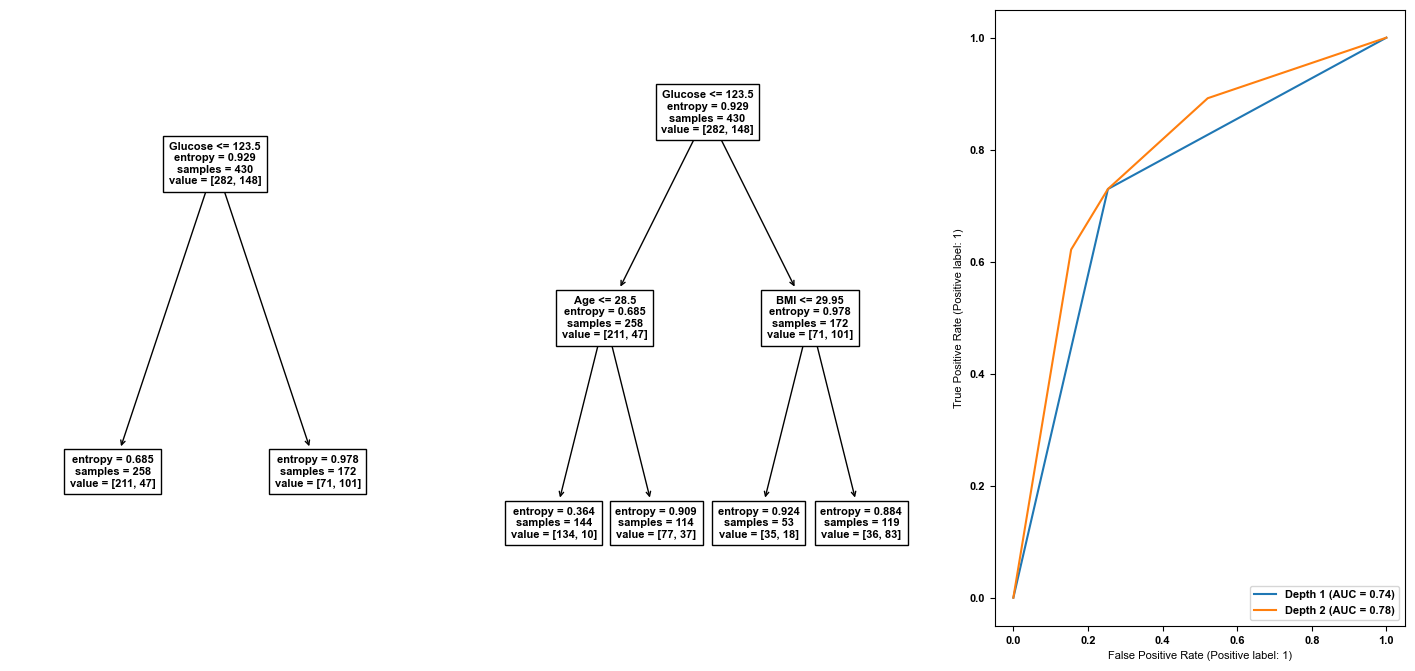

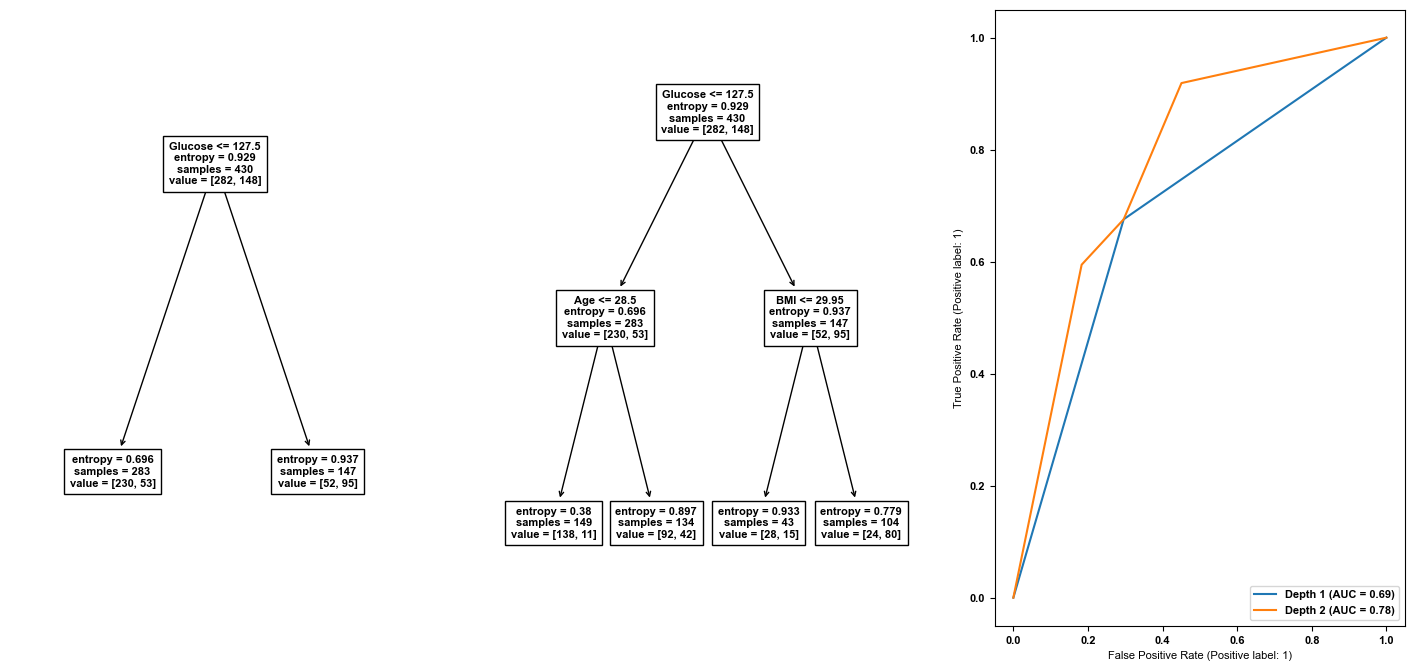

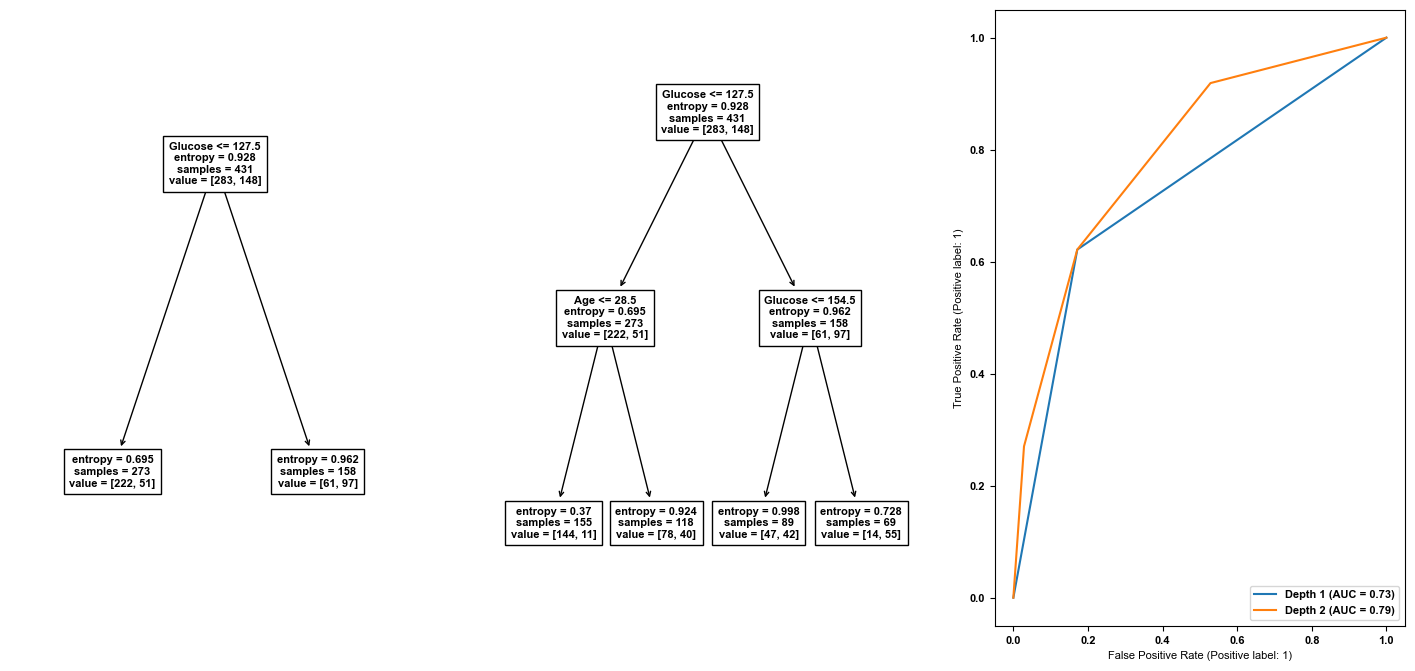

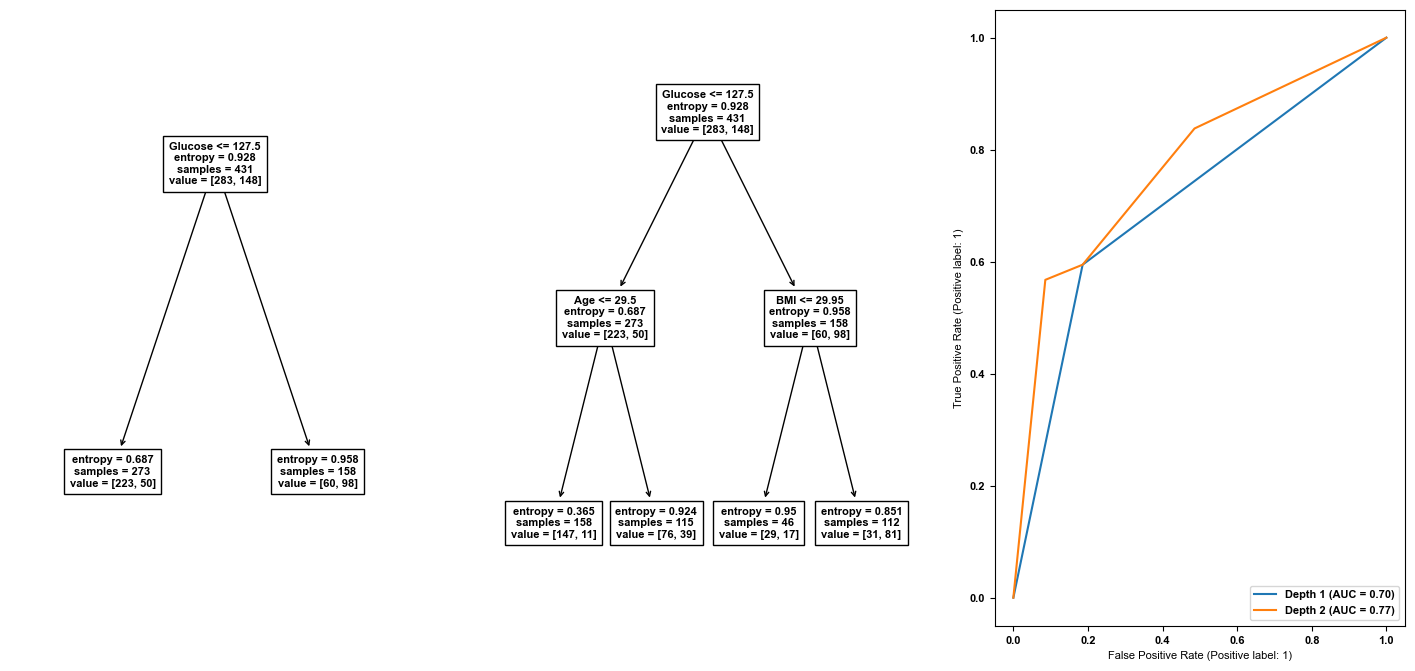

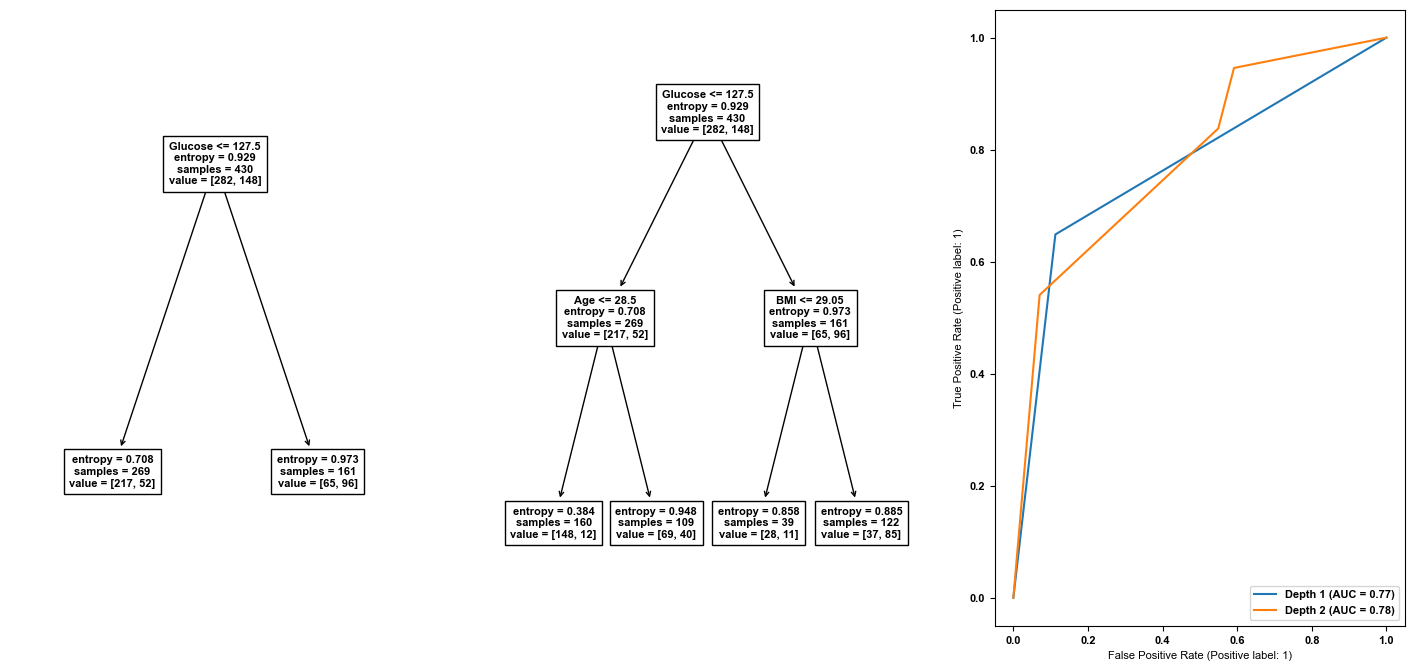

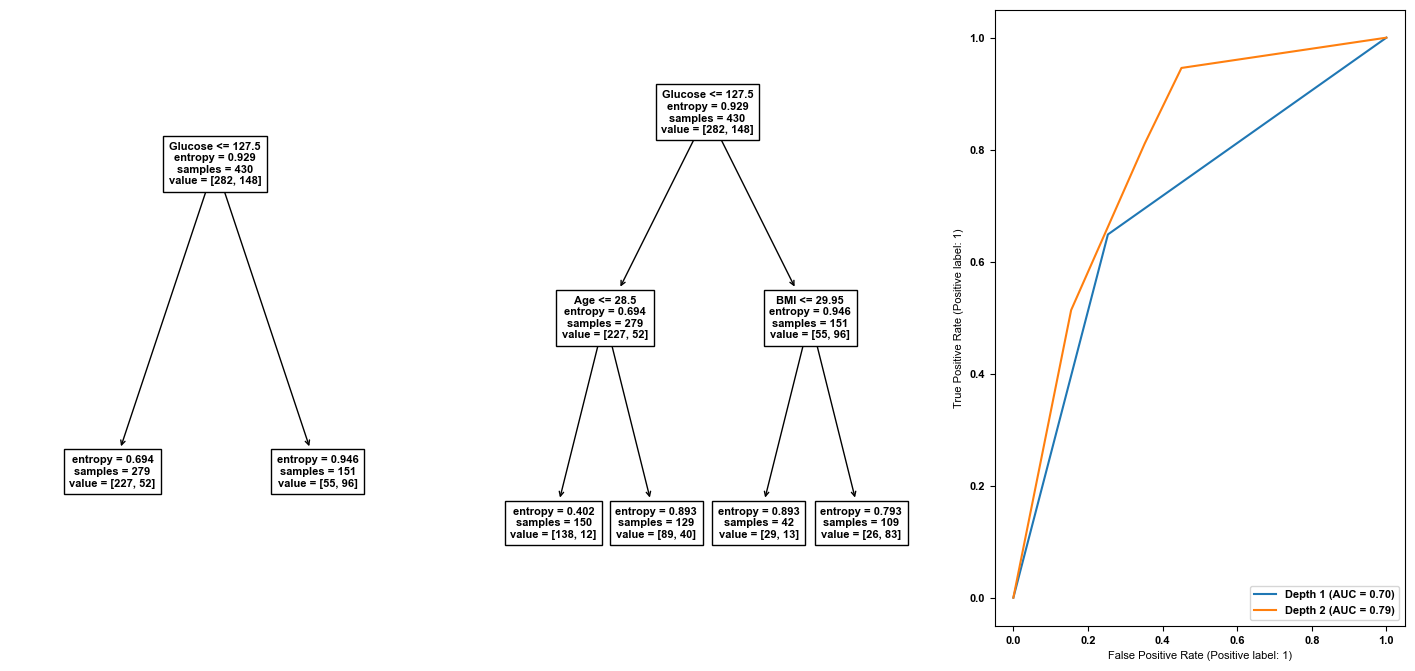

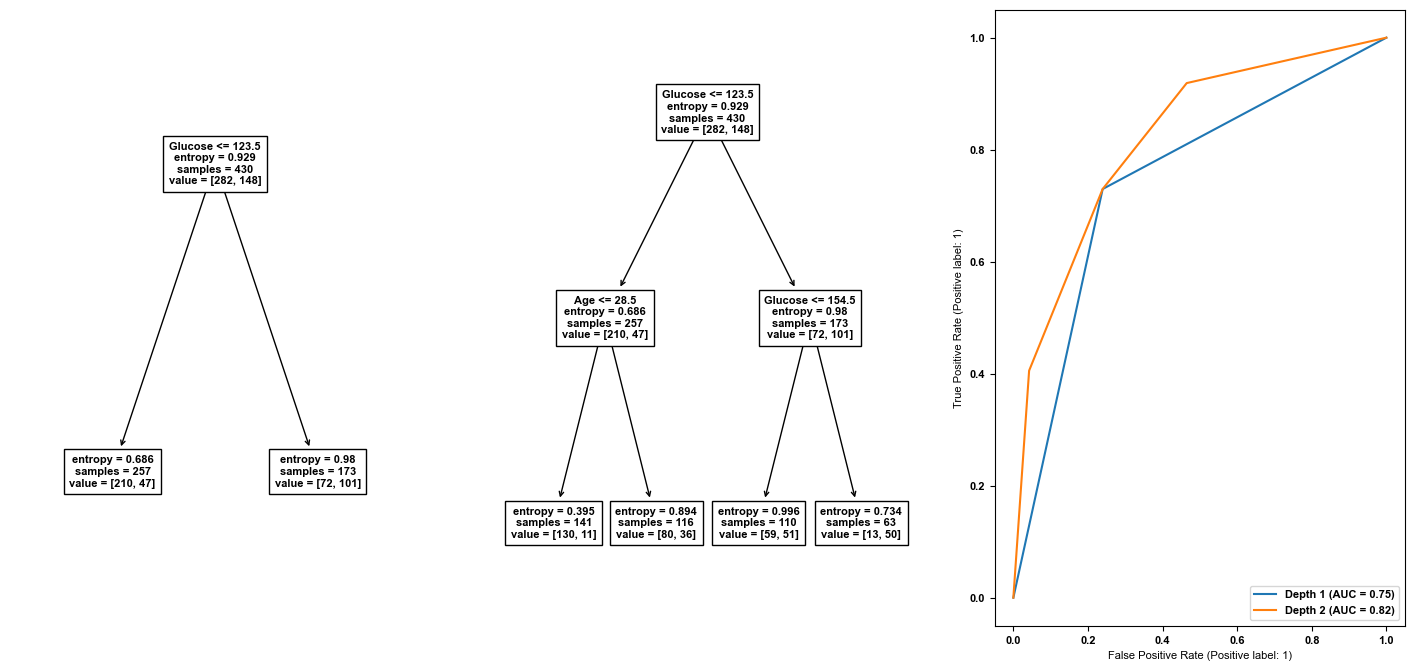

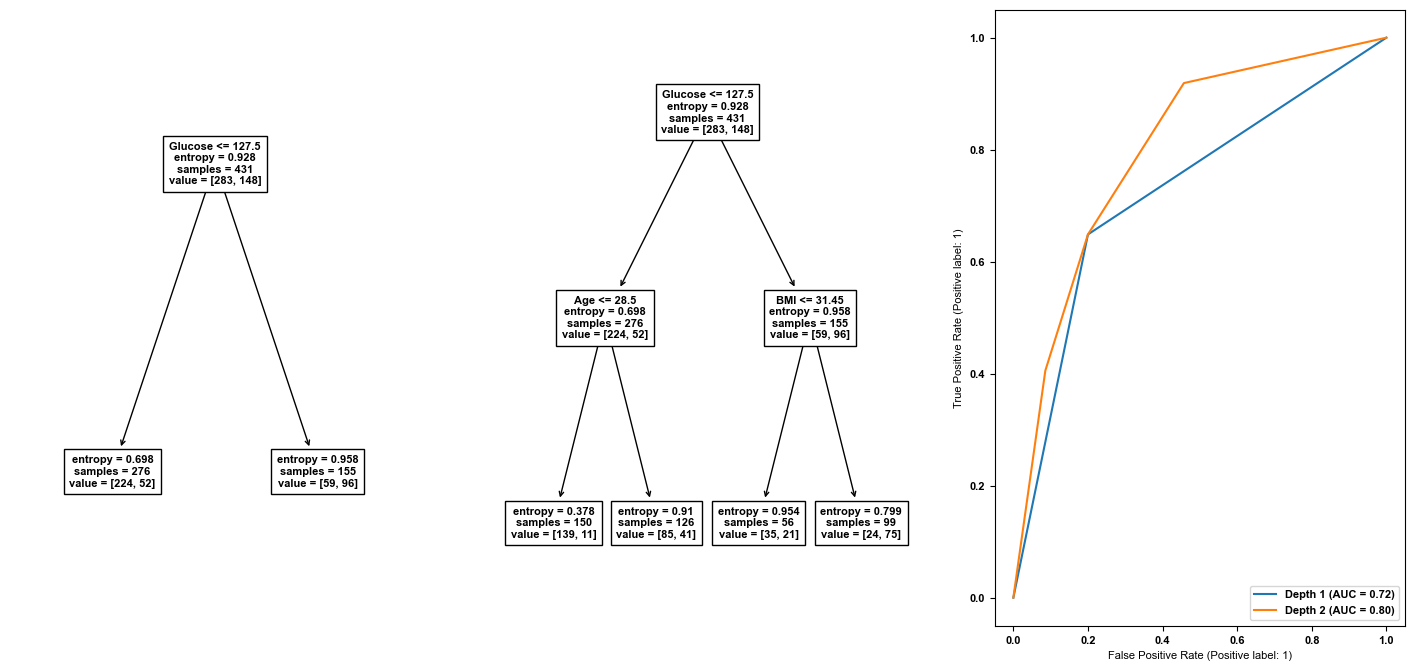

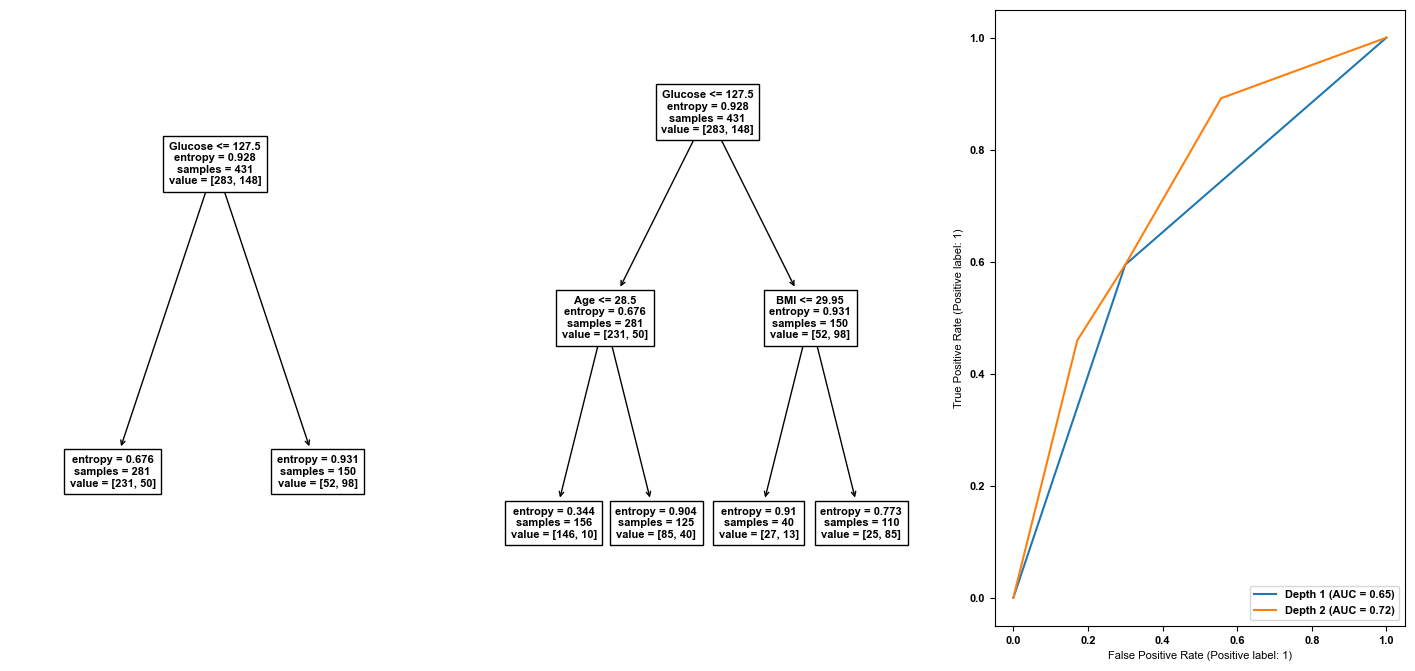

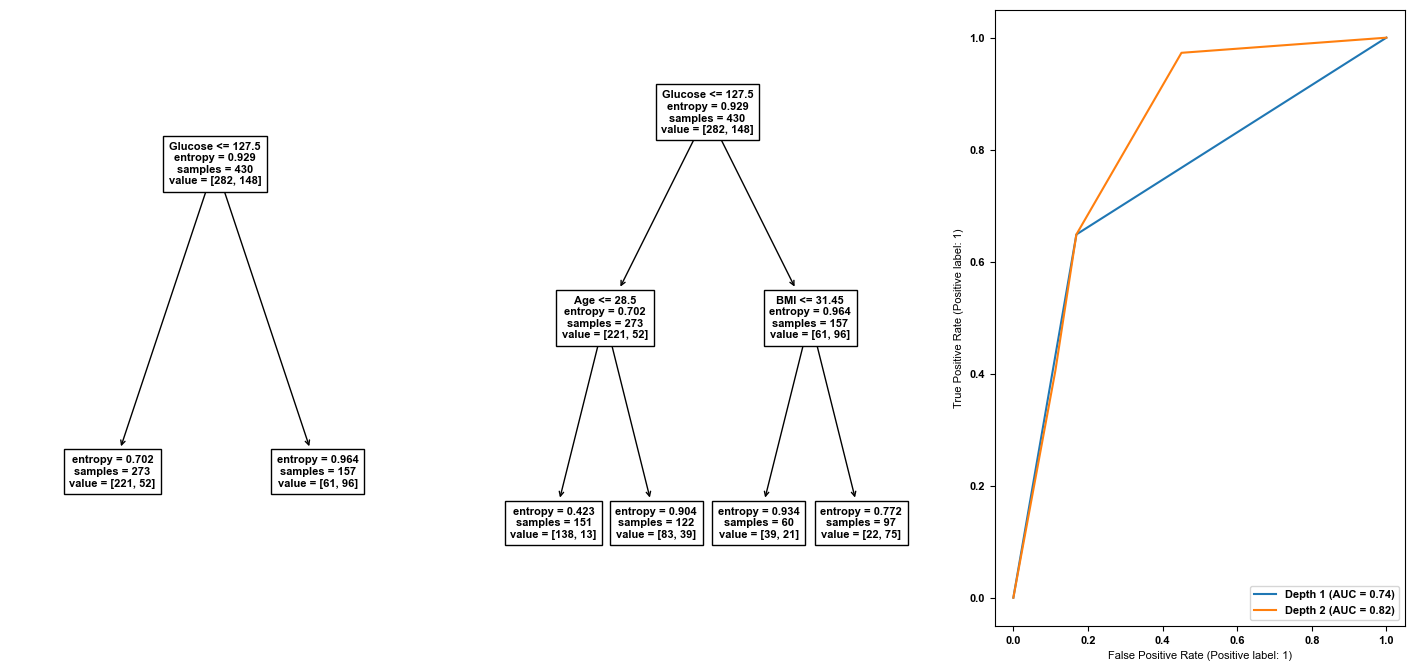

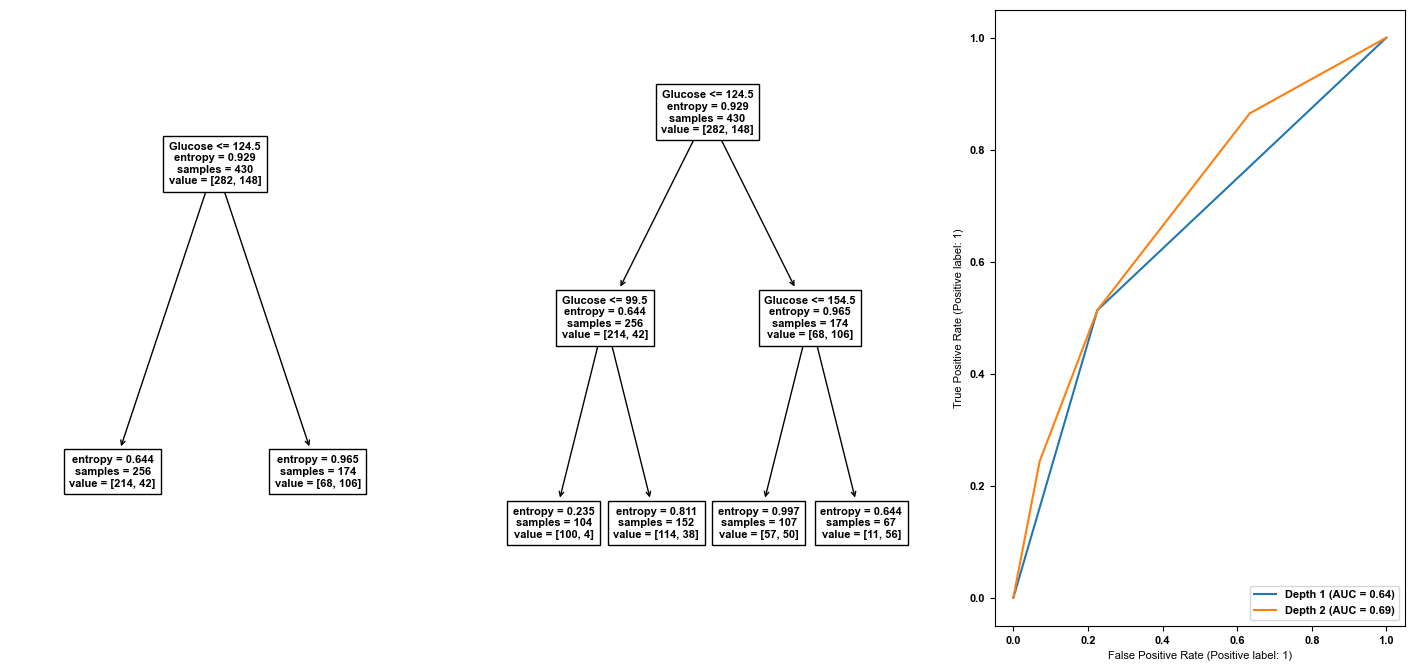

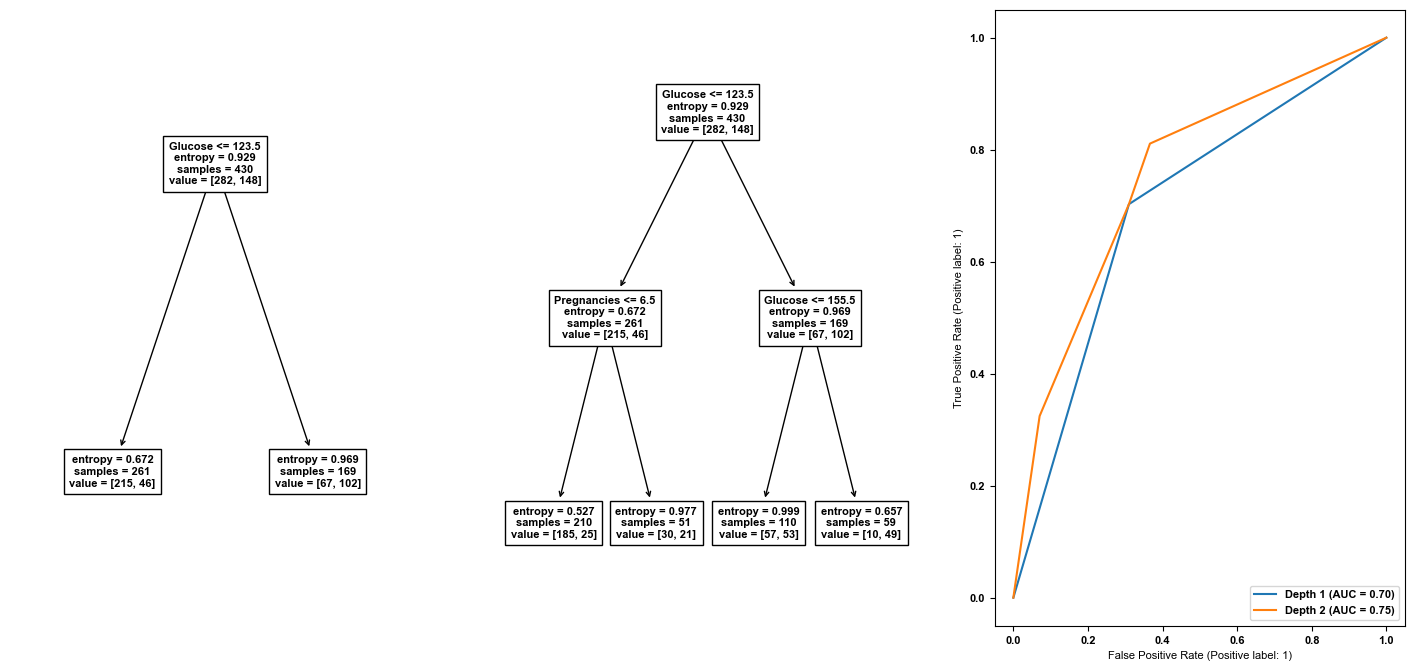

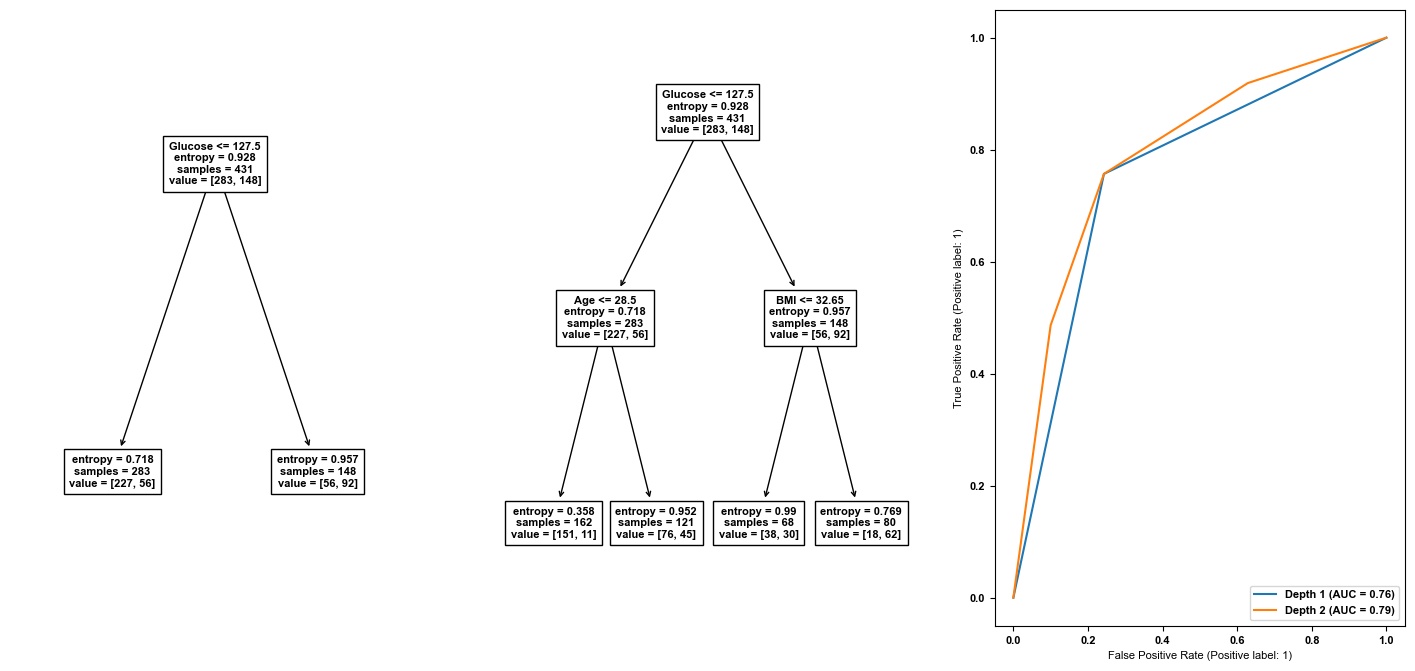

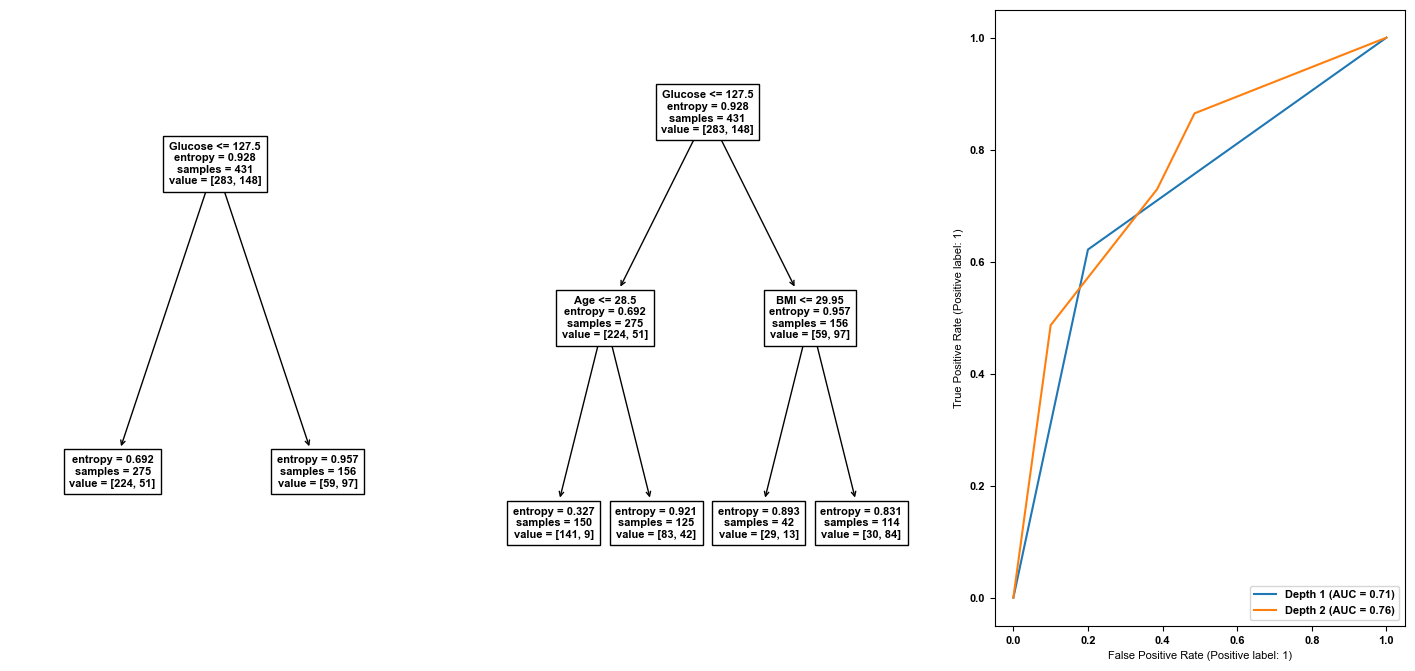

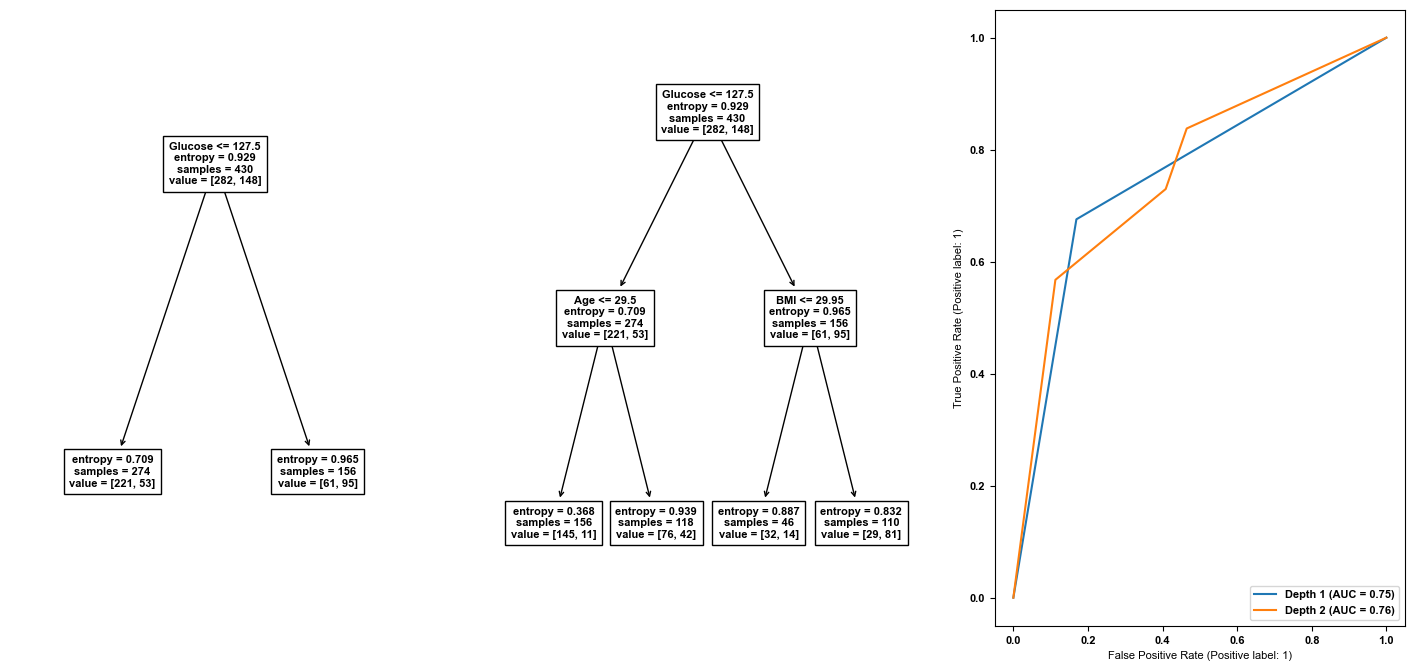

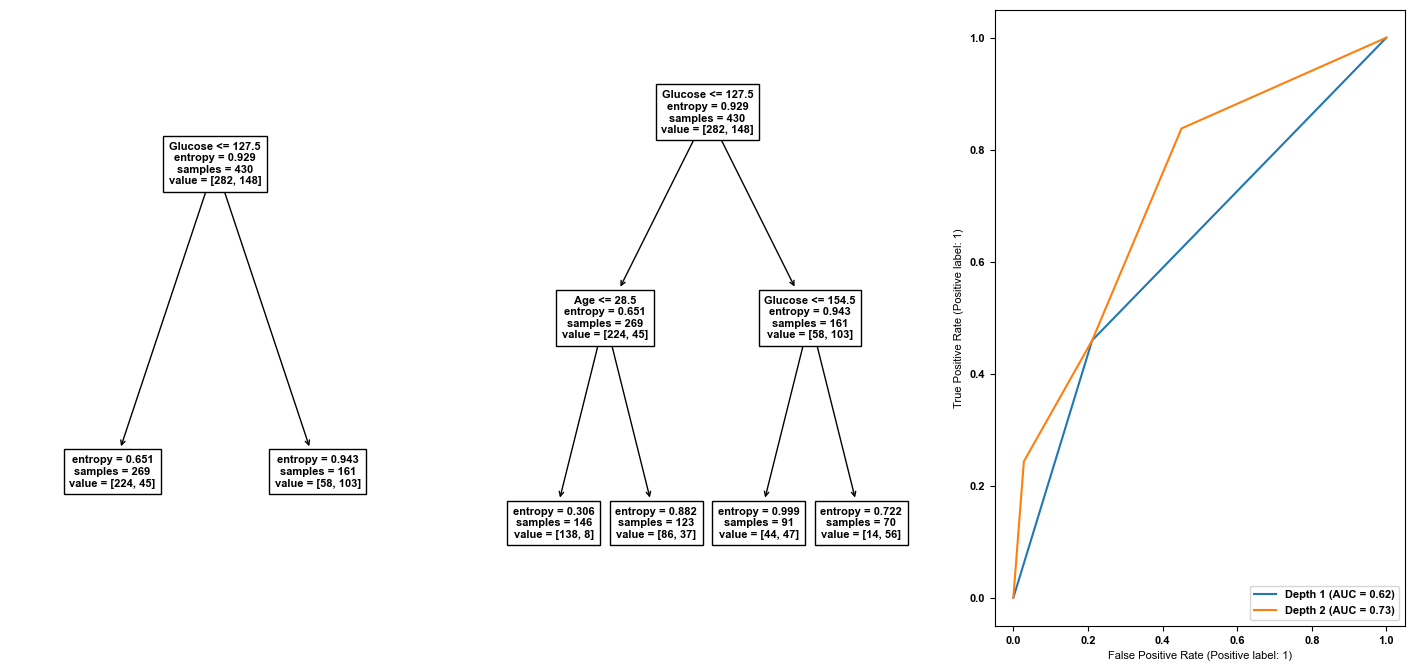

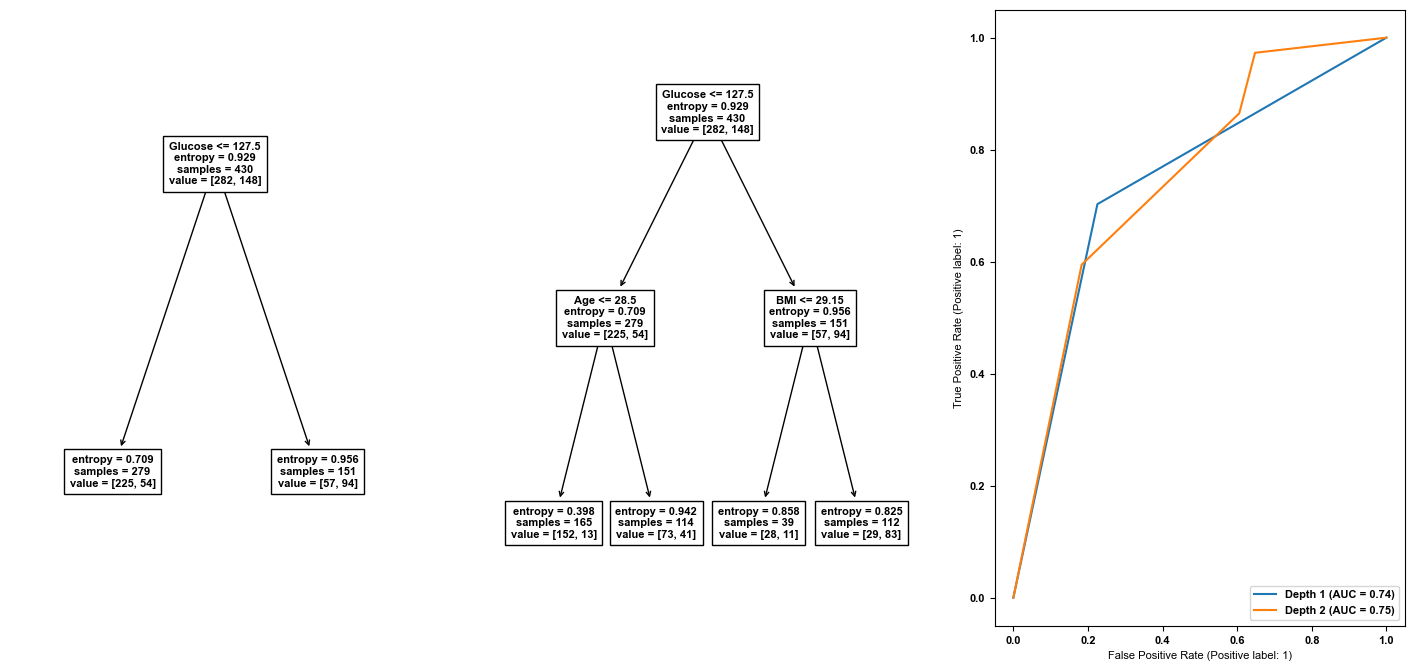

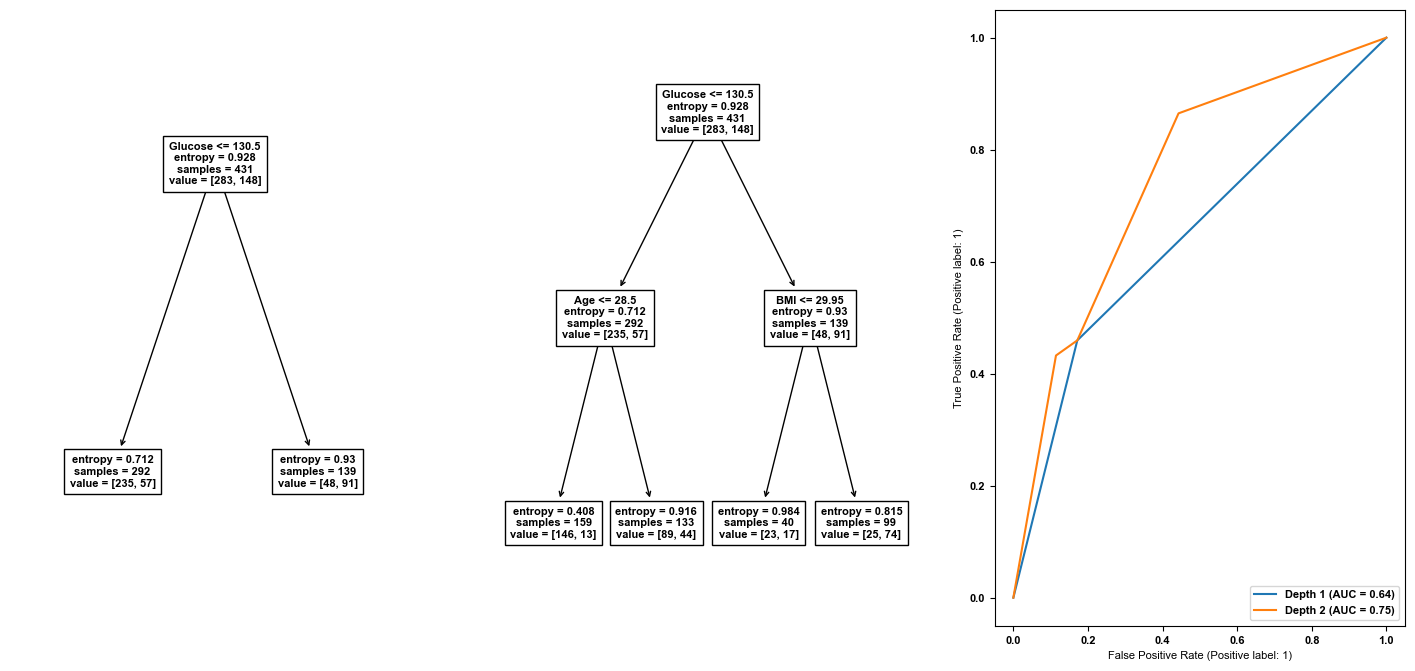

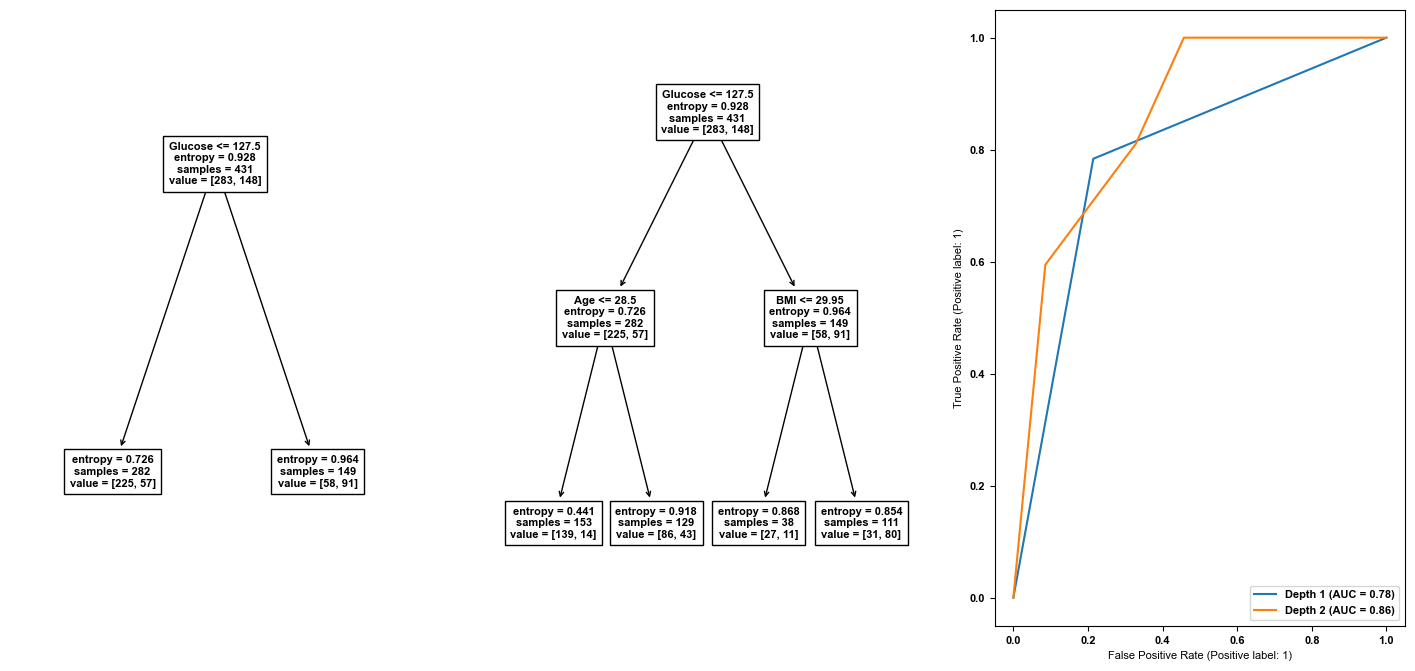

In [113]:
for cv_fold in range(25): 
    fig,axs=plt.subplots(1,3,figsize=[18,8])
    for depth in range(2):
        tree_data=raw_stuff_depth_collect[depth][cv_fold]
        txt=tree.plot_tree(tree_data['decision_tree'],fontsize=8,proportion=False,ax=axs[depth])
        ycollect=[]
        for tx in txt:
            val = tx.get_text()
            num = re.search(r'x\[(\d+)\]',val) 
            if(num is not None): 
                num=int(num.group()[2:-1])
                tx.set_text(tx.get_text().replace(f'x[{num}]',training_data.columns[num]))
        rocDisplay = metrics.RocCurveDisplay.from_predictions(tree_data['validation'],tree_data['model_probability'][:,1],name=f'Depth {depth+1}',ax=axs[2])        
    plt.show()
    

In [121]:
score_depth_summary = scores_depth.groupby('Depth').agg({'Accuracy' :['mean','std'],
                                   'Recall' :['mean','std'],
                                   'Precision' :['mean','std'],
                                   'FPR' :['mean','std'],
                                   'ROC_AUC' :['mean','std']
                                   })

Text(0, 0.5, 'ROC_AUC Std')

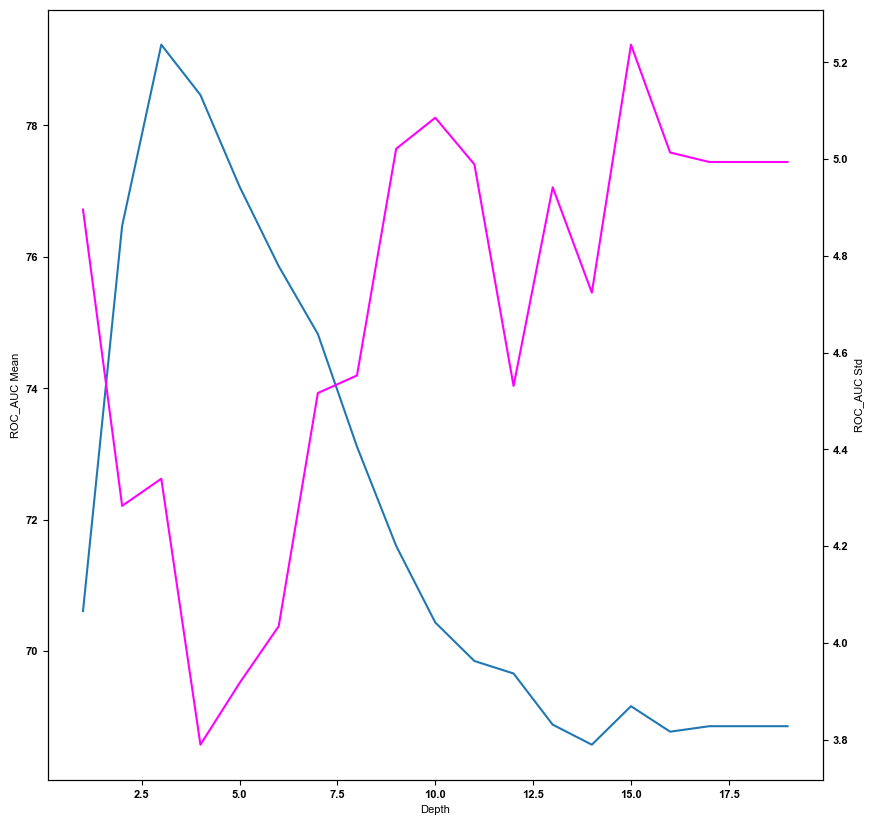

In [122]:

fig,ax1=plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
ax1.set_ylabel('ROC_AUC Mean') 
ax1.set_xlabel('Depth') 
ax1.plot(score_depth_summary.index,score_depth_summary['ROC_AUC']['mean'])

ax2=ax1.twinx()
ax2.plot(score_depth_summary.index,score_depth_summary['ROC_AUC']['std'],color='magenta')
ax2.set_ylabel('ROC_AUC Std') 

Text(0, 0.5, 'Accuracy Std')

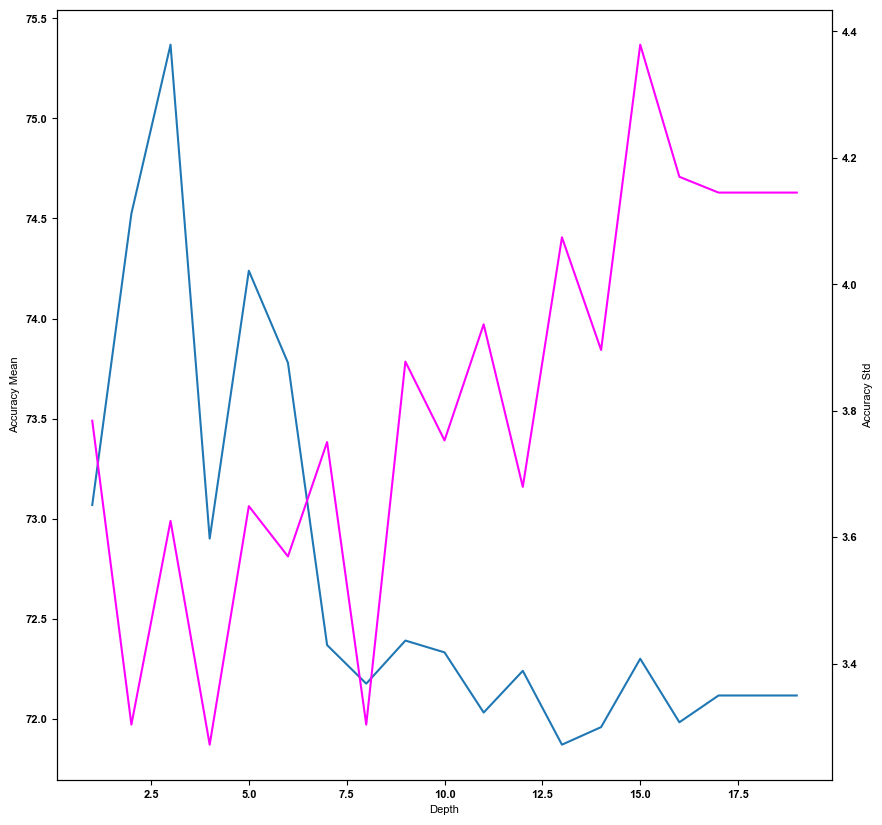

In [123]:
fig,ax1=plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
ax1.set_ylabel('Accuracy Mean') 
ax1.set_xlabel('Depth') 
ax1.plot(score_depth_summary.index,score_depth_summary['Accuracy']['mean'])

ax2=ax1.twinx()
ax2.plot(score_depth_summary.index,score_depth_summary['Accuracy']['std'],color='magenta')
ax2.set_ylabel('Accuracy Std') 

In [60]:
score_depth_summary['Recall']['mean']/score_depth_summary['Recall']['std']

Depth
1     5.604835
2     4.064436
3     4.479085
4     4.514742
5     5.227832
6     6.276477
7     5.716876
8     6.099757
9     6.905063
10    5.661930
11    6.055135
12    6.630660
13    6.130757
14    5.895123
15    5.815921
16    5.859303
17    5.846690
18    5.846690
19    5.846690
dtype: float64

In [61]:
score_depth_summary['FPR']['mean']/score_depth_summary['FPR']['std']

Depth
1     3.955038
2     2.327077
3     2.676141
4     2.422989
5     2.381269
6     2.689353
7     3.186455
8     3.857752
9     3.588757
10    3.698991
11    3.902263
12    4.044516
13    3.861950
14    3.981698
15    3.805032
16    4.035304
17    4.022484
18    4.022484
19    4.022484
dtype: float64

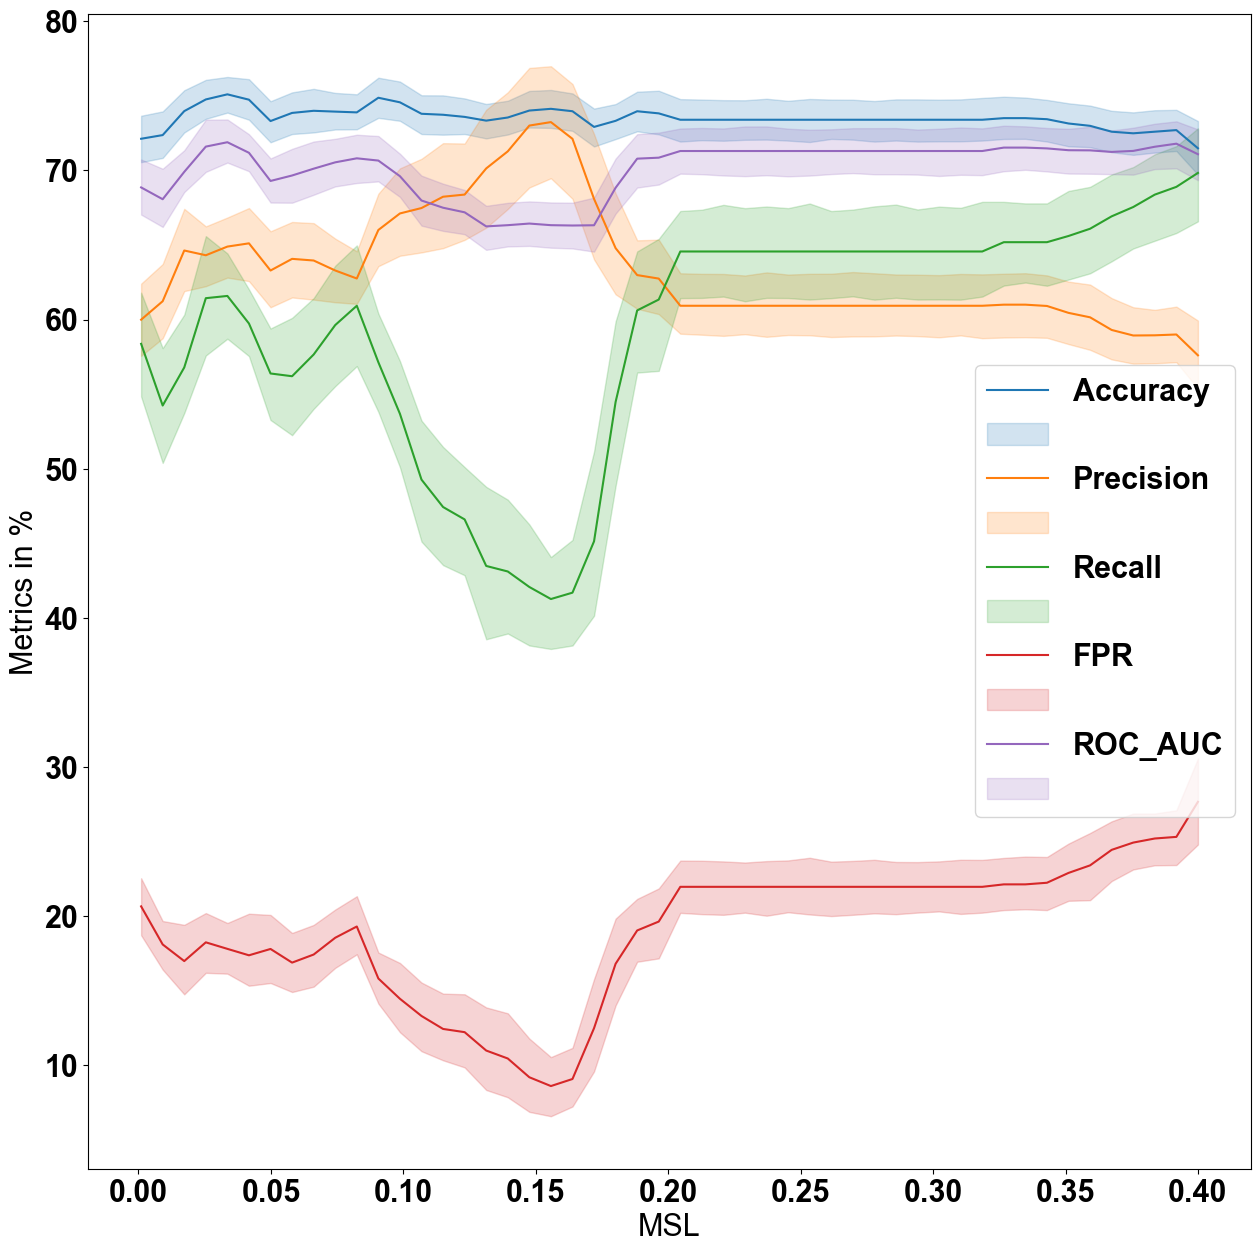

In [29]:
fig = plt.figure(figsize=[15,15])
sns.lineplot(data=scores_msl,x='MSL',y='Accuracy')
sns.lineplot(data=scores_msl,x='MSL',y='Precision')
sns.lineplot(data=scores_msl,x='MSL',y='Recall')
sns.lineplot(data=scores_msl,x='MSL',y='FPR')
sns.lineplot(data=scores_msl,x='MSL',y='ROC_AUC')
plt.legend(['Accuracy','','Precision','','Recall','','FPR','','ROC_AUC',''])
plt.ylabel('Metrics in %')
plt.show()
plt.close()